# 🔬**Cell Segmentation**

<h3>
  <strong>Introduction</strong>
</h3>


> Label-free Cell segmentation is the task of classifying a microscopic image area, pixels representing individual cell instances. It is a fundamental step in many biomedical studies and needs to be meticulously processed.


<h3>
  <strong>Problem Definition</strong>
</h3>

> It is a process that helps the biologist quickly notice the background from the foreground in the cell segmentation task, categorizing pixels into significant regions. Cell segmentation is crucial for biologists to extract cells' morphology, polarity and motility. It increases the accuracy and speed of the diagnosis. It is also more robust and provides reliable results for biologists to use.

Data Source: *TUBITAK 119E578 Cell Motility Phase Contrast Time Lapse Microscopy Data-Set*

<h3>
  <strong>Table of Contents</strong>
</h3>

1.   [Semantic Segmentation with Traditional Machine Learning Methods](#cell-id1)

    1.1. [Data Generator](#cell-id1.1)

    1.2. [Machine Learning Approaches](#cell-id1.2)

2.   [Semantic Segmentation with Deep Learning Methods](#cell-id2) 

    2.1. [Data Generator](#cell-id2.1)
    
    2.2. [Convolutional Neural Networks Approaches](#cell-id2.2)

3.   [Analyzes](#cell-id3)


[References](#cell-id5)


<table class="tfo-notebook-buttons" align="left">
  <td>
        <a class="centered" target="_blank" href="https://github.com/mberkay0"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />© mberkay0</a> 
  </td>

</table>

 

## 🛠 Import Modules 

In [ ]:
%%capture
!pip install mahotas

In [ ]:
%%capture
!pip install segmentation-models==1.0.1
import segmentation_models as sm
sm.set_framework('tf.keras')

In [ ]:
import numpy as np
import cv2
import pickle
import os 
import re
import progressbar

from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from skimage.feature import canny
from skimage import feature
import mahotas as mt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from keras import backend as K
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

In [ ]:
def visualize(**images):
    """
    PLot images in one row.
    Parameters
    ----------
    **images : ndarray
        Images sent for plotting.
        input image, ground_truth, generated_mask
    """
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([]) 
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
def plot_loss(history):
    """
    It plots the loss values, which the model is evaluated during 
    the training and validation step, for each epoch.
    Parameters
    ----------
    history : keras.callbacks.History
        This callback is automatically applied to every Keras model. 
        The History object gets returned by the fit method of models.
    """
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=history.history['loss'],
        mode='lines',
        name='train loss',
        marker_size=8,
        marker_line_width=2
    ))

    fig.add_trace(go.Scatter(
        y=history.history['val_loss'],
        mode='lines',
        name='val loss',
        marker_size=8,
        marker_line_width=2
    ))


    fig.update_layout(
        title_text='Model Loss',
        showlegend=True,
        yaxis=dict(
            title="loss",
            showgrid=False,
            showline=False, 
            showticklabels=True,
        ),
        xaxis=dict(
            title="epoch",
            zeroline=False,
            showline=False,
            showticklabels=True,
            showgrid=True,
            ticks="outside",
            tickson="boundaries",
            ticklen=5
        ),
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        width=750,
        height=600)
    fig.show()

In [ ]:
train_img_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/train/images'
train_mask_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/train/masks'
val_img_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/val/images'
val_mask_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/val/masks'
test_img_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/test/images'
test_mask_path = '/content/gdrive/MyDrive/Datas/cell_motility_data/test/masks'

<a name="cell-id1"></a>
## **1.** 🖱 Traditional Machine Learning for Semantic Segmentation





<h3>
  <strong>1.1 Local Binary Patterns</strong>
</h3>


<div>
<img src="https://929687.smushcdn.com/2633864/wp-content/uploads/2015/12/lbp_thresholding.jpg?lossy=1&strip=1&webp=1" width="430"/>
</div>

**Figure 1.1.1:** The first step in constructing a LBP is to take the 8 pixel neighborhood surrounding a center pixel and threshold it to construct a set of 8 binary digits.


<div>
<img src="https://929687.smushcdn.com/2633864/wp-content/uploads/2015/12/lbp_calculation-1024x299.jpg?lossy=1&strip=1&webp=1" width="450"/>
</div>


<div>
<img src="https://pyimagesearch.com/wp-content/uploads/2015/12/lbp_to_output.jpg" width="450"/>
</div>

**Figure 1.1.2:** Taking the 8-bit binary neighborhood of the center pixel and converting it into a decimal representation. 

<div>
<img src="https://929687.smushcdn.com/2633864/wp-content/uploads/2015/12/lbp_num_points_radii.jpg?lossy=1&strip=1&webp=1" width="350"/>
</div>

**Figure 1.1.3:** Three neighborhood examples with varying p and r used to construct Local Binary Patterns.



<h3>
  <strong>1.2 2D Spatial Filtering Features</strong>
</h3>


<div>
<img src="https://sbme-tutorials.github.io/2018/cv/images/2DConv.png" width="500"/>
</div>

**Figure 1.2.1:** Example of 2D spatial filtering.

<h3>
  <strong>1.3 Haralick Texture Features</strong>
</h3>


<div>
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-017-04151-4/MediaObjects/41598_2017_4151_Fig4_HTML.jpg?as=webp" width="630"/>
</div>

**Figure 1.3.1:** A description of how Haralick’s texture features are calculated. In an example 4 × 4 image ROI, three gray levels are represented by numerical values from 1 to 3. The GLCM is constructed by considering the relation of each voxel with its neighborhood. In this example we only look at the neighbor to the right. The GLCM acts like a counter for every combination of gray level pairs in the image. For each voxel, its value and the neighboring voxel value are counted in a specific GLCM element. The value of the reference voxel determines the column of the GLCM and the neighbor value determines the row. In this ROI, there are two instances when a reference voxel of 3 “co-occurs” with a neighbor voxel of 2, indicated in solid blue, and there is one instance of a reference voxel of 3 with a neighbor voxel of 1, indicated in dashed red. The normalized GLCM represents the frequency or probability of each combination to occur in the image. The Haralick texture features are functions of the normalized GLCM, where different aspects of the gray level distribution in the ROI are represented. For example, diagonal elements in the GLCM represent voxels pairs with equal gray levels. The texture feature “contrast” gives elements with similar gray level values a low weight but elements with dissimilar gray levels a high weight. It is common to add GLCMs from opposite neighbors (e.g. left-right or up-down) prior to normalization. This generates symmetric GLCMs, since each voxel has been the neighbor and the reference in both directions. The GLCMs and texture features then reflect the “horizontal” or “vertical” properties of the image. If all neighbors are considered when constructing the GLCM, the texture features are direction invariant.

*Textural Features*
1. Angular Second Moment

$f_1=Σ_iΣ_j{{p(i,j)}}^2$

2. Contrast

$f_2=Σ_{n=0}^{N_{g-1}} n^2(Σ_{i=1}^{N_g} Σ_{j=1}^{N_g}p(i,j))$

3. Correlation

$f_3=\frac{Σ_iΣ_j(ij)p(i,j)-\mu_x\mu_y}{\sigma_x\sigma_y}$

4. Variance

$f_4=Σ_iΣ_j(i-μ)^2p(i,j)$

5. Inverse Difference Moment 

$f_5=Σ_iΣ_j\frac{1}{1+(i-j)^2}p(i,j)$

6. Sum Average

$f_6=Σ_{i=2}^{2N_g}ip_{x+y}(i)$

7. Sum Varience

$f_7=Σ_{i=2}^{2N_g}(i-f_8)^2p_{x+y}(i)$

8. Sum Entropy

$f_8=-Σ_{i=2}^{2N_g}p_{x+y}(i)log{(p_{x+y}(i))}$

9. Entropy

$f_9=Σ_iΣ_jp(i,j)log{(p(i,j))}$

10. Difference Varience

$f_{10}=varience\:of\:p_{x-y}$

11. Difference Entropy

$f_{11}=-Σ_{i=0}^{N_{g-1}}p_{x-y}(i)log{(p_{x-y}(i))}$

12. Information Features of Correlation

$f_{12}=\frac{HXY-HXY1}{max(HX,HY)}$,
$f_{13}=(1-exp[-2(HXY2-HXY)])^\frac{1}{2}$,
$HXY=-Σ_iΣ_jp(i,j)log{(p(i,j))}$,
$HXY1=-Σ_iΣ_jp(i,j)log{(p_x(i)p_y(j))}$,
$HXY2=-Σ_iΣ_jp_x(i)p_y(j)log{(p_x(i)p_y(j))}$

<a name="cell-id1.1"></a>
###Data Generator

In [ ]:
class DataGenerator(object): 
    """
    Suitable for building data generator for training and prediction.
    It generates features and labeled data to train traditional 
    machine learning methods in semantic segmentation. For this, it is 
    sufficient to provide only the main directories of the image and labeled data.
    Parameters
    ----------
    img_path : string
        The main directory with images.
    mask_path : string, default=None
        The main directory with masks.
    feature_type : string, default='haralick'
        Must be 'haralick' or 'filtered'. 
        Features are calculated using Haralick or 2D spatial filters. 
        For this, set the parameter to 'haralick' or 'filtered'. 
        It is currently set to Haralick.
    num_of_feature : int
        Number of features for Haralick texture features.
        There are 13 Haralick features. This is not about the 
        properties of 2D Spatial Filters. The filter features 
        are only 8 different features.
    to_fit : boolean, default=True
        Create a data generator based on this parameter 
        for training or prediction. True to return X and y, 
        False to return X only.
    batch_size : int, default=32
        It is the batch size taken from the dataset. If it exceeds 
        the number of available datasets, the generated data may 
        fall into repetition.
    num_of_samples : int, default=1000
        Number of example pixels per image to use for training model.
    normalize : boolean, default=True
        Scale input data individually by min-max scaler.
        X_scaled = x - min(x) / max(x) - min(x)
    lbp_radius : int, default=24
        Local binary pattern neighbourhood.
        More information: https://mahotas.readthedocs.io/en/latest/lbp.html
    h_neighborhood : int, default=11
        Feature neighbourhood. Neighbourhood (in pixels) 
        to compute output different feature values.
    dim : tuple or list, default=(256, 256)
        Tuple indicating for image dimension.
        Use it to quickly generate predictions.
    shuffle : boolean, default=False
        It takes effect if the batch size entered exceeds the number of instances 
        in the dataset. After the data is finished, it shuffles the data 
        to select and the pixels to select.
    seed : int, seed instance or None, default=None
        Determines random number generation for shuffle label indexes. 
        Use an int to make the randomness deterministic.
    """
    def __init__(self, img_path, mask_path=None, feature_type='haralick',
                 num_of_feature=9, to_fit=True, batch_size=32, num_of_samples=1000, 
                 normalize=True, lbp_radius=24, h_neighborhood=11, dim=(256, 256), 
                 n_classes=1, shuffle=False, seed=None):

        self.feature_type = feature_type.lower()
        self.num_of_feature = num_of_feature
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.num_of_samples = num_of_samples
        self.normalize = normalize
        self.lbp_radius = lbp_radius
        # 2, 4, 8 for just use neighborhood 8 connectivity
        self.lbp_points = self.lbp_radius * 8 
        self.h_neighborhood = h_neighborhood
        # Step (in pixels) to compute output texture values. 
        # The first computed pixel position is shifted by (step-1)/2 in both directions.
        self.h_indices = int((self.h_neighborhood - 1) / 2)
        self.ssIDs_batches = []
        self.dim = dim
        self.shuffle = shuffle
        self.seed = seed
        self._n_batch = 0
        self._initialize_dirs(img_path, mask_path)
        self.on_data_end()
        self._check_params()

        if self.seed is not None:
                np.random.seed(self.seed)
    
    def _check_params(self):
        if self.feature_type != 'haralick' and self.feature_type != 'filtered':
            raise ValueError(
                f"Feature type must be 'haralick' or 'filtered'," 
                f"got '{self.feature_type}' instead.")
        
        if self.num_of_feature < 0:
            raise ValueError(
                f"num_of_feature should be > 0, got {self.num_of_feature} instead.")
            
        if self.batch_size < 0:
            raise ValueError(
                f"batch_size should be > 0, got {self.batch_size} instead.")
            
        if self.num_of_samples < 0:
            raise ValueError(
                f"num_of_samples should be > 0, got {self.num_of_samples} instead.")
        
        if self.feature_type == 'haralick':
            if self.lbp_radius < 1:
                raise ValueError(
                    f"lbp_radius should be > 1, got {self.lbp_radius} instead.")
                
            if self.h_neighborhood < 0:
                raise ValueError(
                    f"h_neighborhood should be > 0, got {self.h_neighborhood} instead.")
                
        if len(self.dim) != 2:
            raise ValueError(
                f"Image shape should be equal to 2, got {len(self.dim)} instead.")
            
    def __len__(self):
        """
        Denotes the number of datas.
        Returns
        -------    
        num_datas : int    
            Number of datas.
        """
        return len(self.list_IDs)

    def __getitem__(self, index):
        """
        Generate one batch of data.
        Parameters
        ----------
        index : int 
            Index of the batch.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Number of channels image up to batch size.
        y : list of ndarray shape (batch_size, *dim, n_classes)  
            Number of classes image up to batch size.
            X and y when fitting. X only when predicting.
        """
        if self._n_batch >= len(self):
            self.on_data_end
            self._n_batch = 0
            self.ssIDs_batches = []
            index = self._n_batch

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[idx] for idx in indexes]

        self._n_batch += 1
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            X = self._generate_X(list_IDs_temp)
            return X, y
        X = self._generate_X(list_IDs_temp)
        return X            
            
    def on_data_end(self):
        """
        Updates indexes after each data end.
        Attributes
        ----------
        indexes : list of ndarray shape (len(filenames[1]),)
            It keeps the indices as high as the size of the masks.
            If shuffle is True, shuffle the data indices and updates
            after each data end.
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """
        Create a generator that iterate over the DataGenerator.
        """
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item

    def __next__(self):
        """
        Function returns the next batches in a DataGenerator.
        Returns
        ----------
        batches : list of ndarray (X, y) or X
            It is the data prepared as much as the 
            number of batches.
        """
        batches = self.__getitem__(self._n_batch)
        return batches
    
    def _initialize_dirs(self, img_path, mask_path):
        """
        Initialize the all data directories.
        Parameters
        ----------
        img_path : string
            The main directory with images.
        mask_path : string
            The main directory with masks.
        Attributes
        ----------
        image_paths : list, size (1,)
            A list that keeps the full directories of images.
        mask_paths : list, size (1,)
            A list that keeps the full directories of masks.
        list_IDs : list of ndarray shape (len(images),)
            It keeps the indices as high as the size of the images.
        """
        image_paths = []
        mask_paths = []
        for image in next(os.walk(img_path))[-1]:
            image_paths.append(img_path + os.sep + image)

        if mask_path is not None:
            for mask in next(os.walk(mask_path))[-1]:
                mask_paths.append(mask_path + os.sep + mask)
            mask_paths.sort(key=natural_keys)

        image_paths.sort(key=natural_keys)
        

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.list_IDs = np.arange(len(image_paths))

    def _cal_haralick(self, roi):
        """
        Calculate the Haralick features.
        These are texture features, based on the adjacency 
        matrix (the adjacency matrix stores in position (i, j) 
        the number of times that a pixel takes the value i next 
        to a pixel with the value j. Given different ways to 
        define next to, you obtain slightly different variations 
        of the features. Standard practice is to average them 
        out across the directions to get some rotational invariance.
        features={
            "Angular Second Moment",
            "Contrast",
            "Correlation",
            "Sum of Squares: Variance",
            "Inverse Difference Moment",
            "Sum Average",
            "Sum Variance",
            "Sum Entropy",
            "Entropy",
            "Difference Variance",
            "Difference Entropy",
            "Information Measure of Correlation 1",
            "Information Measure of Correlation 2",
            "Maximal Correlation Coefficient"
        }
        Parameters
        ----------
        roi : ndarray
            In an ROI (Region Of Interest), the area of ​​
            interest is samples within a defined data set 
            for a specific purpose.
        Returns
        ----------
        feature_vector : list of ndarray (self.num_of_feature, )
            The feature vector contains the average for 
            each of the computed Haralick features.
        """
        haralick_features = mt.features.haralick(roi)
        mean_haralick = haralick_features.mean(axis=0)
        feature_vector = mean_haralick[:self.num_of_feature]
        return feature_vector

    def _haralick_features(self, img, IDs):
        """
        Extract ROIs and calculate haralick features 
        based on the indices selected for the given image.
        Parameters
        ----------
        img : ndarray (N, M)
            Given 2D gray scale image.
        IDs : ndarray
            Selected pixel indices from flattened image.
        Returns
        ----------
        haralick_features : list of ndarray (self.num_of_feature, )
            The feature vector contains the average for 
            each of the computed Haralick features. 
        """
        shape = (
            img.shape[0] - self.h_neighborhood + 1, 
            img.shape[1] - self.h_neighborhood + 1, 
            self.h_neighborhood, self.h_neighborhood
        )
        rois = np.lib.stride_tricks.as_strided(
            img, shape=shape, strides=2*img.strides
        )
        rois = rois.reshape(-1, self.h_neighborhood, self.h_neighborhood)

        if len(IDs):
            haralick_features = np.array(
                [self._cal_haralick(roi) for roi in rois[IDs]]
            )
        else:
            haralick_features = np.array(
                [self._cal_haralick(roi) for roi in rois]
            )
        return haralick_features

    def _2Dfiltered_features(self, img, IDs):
        """
        Extract ROIs and calculate 2D filter features 
        based on the indices selected for the given image.
        features={
            Canny edge,
            Roberts edge,
            Sobel,
            Scharr,
            Prewitt,
            Gaussian with sigma=3,
            Gaussian with sigma=7,
            Hessian, 
            Laplace
        }
        Parameters
        ----------
        img : ndarray (N, M)
            Given 2D gray scale image.
        IDs : ndarray
            Selected pixel indices from flattened image.
        Returns
        ----------
        filtered_features : list of ndarray (self.num_of_feature, )
            The feature vector contains the average for 
            each of the filtered image features. 
        """
        if len(IDs):
            filtered_features = np.array([
                canny(img, sigma=3).reshape(-1).astype(int)[IDs],
                roberts(img).reshape(-1)[IDs],
                sobel(img).reshape(-1)[IDs],
                scharr(img).reshape(-1)[IDs],
                prewitt(img).reshape(-1)[IDs],
                gaussian(img, sigma=3).reshape(-1)[IDs],
                gaussian(img, sigma=7).reshape(-1)[IDs],
                hessian(img).reshape(-1)[IDs],
                laplace(img).reshape(-1)[IDs]
                
            ])
        else:
            filtered_features = np.array([
                canny(img, sigma=3).reshape(-1).astype(int),
                roberts(img).reshape(-1),
                sobel(img).reshape(-1),
                scharr(img).reshape(-1),
                prewitt(img).reshape(-1),
                gaussian(img, sigma=3).reshape(-1),
                gaussian(img, sigma=7).reshape(-1),
                hessian(img).reshape(-1),
                laplace(img).reshape(-1)
            ])

        filtered_features = filtered_features.reshape(
            filtered_features.shape[1], filtered_features.shape[0]
        )
        return filtered_features

    def _local_binary_pattern(self, img, P, R):
        """
        For each pixel in the grayscale image, we select a neighborhood 
        of size r surrounding the center pixel. A LBP value is then 
        calculated for this center pixel and stored in the output 
        2D array with the same width and height as the input image.

        Gray scale and rotation invariant LBP (Local Binary Patterns).
        LBP is an invariant descriptor that can be used for texture classification.
        Parameters
        ----------
        img : ndarray (N, M)
            Given 2D gray scale image.
        P : int
            Number of circularly symmetric neighbour set points (quantization of
            the angular space).
        R : float
            Radius of circle (spatial resolution of the operator).
        Returns
        ----------
        lbp : ndarray (N, M)
            LBP image.
        """
        lbp = feature.local_binary_pattern(img, P, R)
        lbp = (lbp-np.min(lbp)) / (np.max(lbp)-np.min(lbp)) * 255
        return lbp

    def _extract_features(self, img, img_gray, subsample_IDs):
        """
        The feature vector contains the average for each of the 
        computed Haralick or filtered features and pixel-wise 
        features, local binary patterns.
        Parameters
        ----------
        img : ndarray (N, M, 3)
            Given RGB image (3 channel).
        img_gray : ndarray (N, M)
            Given 2D gray scale image.
        Returns
        ----------
        features : list of ndarray (num_of_samples, self.num_of_feature + 4)
            Calculated feature vector for each pixel sample.
        """
        img = np.append(img, np.zeros((img.shape[0], img.shape[1], 1)), axis=2)
        img[:,:,3] = self._local_binary_pattern(
            img_gray, self.lbp_points, self.lbp_radius
        )
        img = img[self.h_indices:-self.h_indices, 
                  self.h_indices:-self.h_indices]
        features = img.reshape(
            img.shape[0]*img.shape[1], 
            img.shape[2]
        )
        if len(subsample_IDs):
            features = features[subsample_IDs]
        if self.feature_type == 'haralick':
            ex_features = self._haralick_features(img_gray, subsample_IDs)
        else:
            img_gray = img_gray[self.h_indices:-self.h_indices, 
                                self.h_indices:-self.h_indices]
            ex_features = self._2Dfiltered_features(img_gray, subsample_IDs)
        features = np.hstack((features, ex_features))
        return features

    def _get_subsample(self, labels, sample_size, weighted=True):
        """
        Return random indices from given labels.
        Parameters
        ----------
        labels : list of ndarray 
            It is the labeled data of each pixel in the given image.
            above the highest such integer).
        sample_size : int or tuple of ints, optional
            Output shape. If the given shape is, e.g., (m, n, k), 
            then m * n * k samples are drawn. Default is None, in which 
            case a single value is returned.
        Returns
        ----------
        subsample_IDs : ndarray (sample_size, )
            Size-shaped array of random integers from the appropriate 
            distribution, or a single such random int if size not provided.
        """
        if weighted:
            zeros = np.where(labels == 0)[0]
            ones = np.where(labels == 1)[0]
            zero_IDs = np.random.choice(
                zeros, size=sample_size//2, replace=False
            )
            one_IDs = np.random.choice(
                ones, size=sample_size//2, replace=False
            )
            subsample_IDs = np.hstack([zero_IDs, one_IDs])
        else:
            subsample_IDs = np.random.randint(0, labels.shape[0], sample_size)
        return subsample_IDs

    def _generate_X(self, list_IDs_temp):
        """
        Generates data containing batch_size features.        
        Parameters
        ----------
        list_IDs_temp : list
            List of images ids to load.
        Returns
        ----------
        X : list of ndarray shape (batch_size*num_of_samples, num_of_features)
            Batch of features.
        """
        X = []
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(self.image_paths[ID])
            if not self.to_fit:
                img = cv2.resize(img, self.dim)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                features = self._extract_features(img, img_gray, [])
            else:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                features = self._extract_features(img, img_gray, self.ssIDs_batches[i])
            X.append(features)

        X = np.array(X)
        X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
        if self.normalize:
            X = (X - 0) / (255 - 0) 
        return X

    def _generate_y(self, list_IDs_temp):
        """
        Generates data containing batch_size labels.
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        y : list of ndarray shape (batch_size*num_of_samples, )
            Batch of labels.
        """
        y = []
        for ID in list_IDs_temp:
            label = cv2.imread(self.mask_paths[ID], 0)
            label[:, :][label[:, :] > 1] = 1
            label = label[self.h_indices:-self.h_indices, 
                          self.h_indices:-self.h_indices]
            labels = label.reshape(label.shape[0] * label.shape[1], 1)

            subsample_IDs = self._get_subsample(
                labels, self.num_of_samples
            )
            self.ssIDs_batches.append(subsample_IDs)
            labels = labels[subsample_IDs]
            y.append(labels)
            
        y = np.array(y)
        y = y.reshape(y.shape[0] * y.shape[1], y.shape[2]).ravel()
        return y    

<a name="cell-id1.2"></a>
###  ML Approaches

In [ ]:
class TraditionalImageSegmentation(object):
    """
    Base class for image semantic segmentation with ML techniques.
    Parameters
    ----------
    model : scikit-learn ML model
        scikit-learn Supervised Learning Model for classification problem.
    train_generator : DataGenerator object
        It is an object that creates the necessary data set for 
        the training phase.
    val_generator : DataGenerator object, default=None
        It is an object that creates the necessary data set for 
        the validation phase. If it is None, the split_size parameter 
        must be entered. In this way, the model validation dataset is 
        obtained from the training dataset.
    split_size : float, default=0.2
        Should be between 0.0 and 1.0 and represent the proportion 
        of the dataset to include in the test split. If val_generator 
        is None, set this parameter.
    seed : int, default=None
        Controls the shuffling applied to the data before applying 
        the split. Pass an int for reproducible output across 
        multiple function calls. 
    save : boolean, default=False
        If true, the directory where the model will be saved must 
        be entered.
    save_path : string, default=None
        The model's save directory. It should include: 
        model save directory and model name. 
        For example; */.user/ML_segmentation_model.sav
    verbose : boolean, default=True
        If true, the model prints the necessary information 
        during and after the training phase.
    """
    def __init__(self, model, train_generator, val_generator=None,
                 split_size=0.2, seed=None, save=False, save_path=None, verbose=True):

        self.model = model
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.split_size = split_size
        self.seed = seed
        self.save = save
        self.save_path = save_path
        self.verbose = verbose
        self._check_params()

    def _check_params(self):

        if self.save == True and self.save_path == None:
            raise ValueError(
                f"If the model is to be saved, you must specify the file path.")
            
        if not (self.split_size > 0.0 and self.split_size < 1.0):
            raise ValueError(
                f"split_size should be > 0.0 and < 1.0, got {self.split_size} instead.")


    def train(self):
        """
        Fit the model according to the given training data (train_generator).
        Returns
        -------
        model : scikit-learn ML model
            An instance of the fitted estimator.
        """
        print('[INFO] Preparing the dataset...')
        X, y = next(self.train_generator)
        if self.val_generator is None:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=self.split_size, random_state=self.seed
            )
        else:
            X_train, y_train = X, y
            X_test, y_test = next(self.val_generator)

        print('[INFO] Training {} model...'.format(type(self.model).__name__))
        self.model.fit(X_train, y_train)

        print('[INFO] Model training complete.')
        print('[INFO] Training Accuracy: {:.2f}'.format(self.model.score(X, y)))

        if self.save:
            pickle.dump(self.model, open(self.save_path, "wb"))

        if self.verbose:
            precision, recall, f1, accuracy = self.evaluate(
                X_test, y_test, self.model
            )
            print('-'*30)
            print('      Evaluation Results      ')
            print('-'*30)
            print('[RESULTS] Accuracy: {:.2f}'.format(accuracy))
            print('[RESULTS] Precision: {:.2f}'.format(precision))
            print('[RESULTS] Recall: {:.2f}'.format(recall))
            print('[RESULTS] F1 Score: {:.2f}'.format(f1))
            print('-'*30)
        return self.model


    def evaluate(self, X, y, model):
        """
        Evaluate the given X and y for specified model.
        Parameters
        ----------
        X: ndarray
            Given features.
        y: ndarray
            Given ground truths (labels).
        model : scikit-learn ML model
            scikit-learn Supervised Learning Model for classification problem.
        Returns
        -------
        precision : float
            Computed precision. The precision is the ratio 
            tp / (tp + fp) where tp is the number of true 
            positives and fp the number of false positives. 
            The precision is intuitively the ability of the 
            classifier not to label as positive a sample that is negative.
        recall : float
            Computed recall. The recall is the ratio 
            tp / (tp + fn) where tp is the number of 
            true positives and fn the number of false 
            negatives. The recall is intuitively the 
            ability of the classifier to find all the 
            positive samples. 
        f1 : float
            Computed F1 score, also known as balanced 
            F-score or F-measure. The F1 score can be 
            interpreted as a harmonic mean of the precision 
            and recall, where an F1 score reaches its best 
            value at 1 and worst score at 0. The relative 
            contribution of precision and recall to the F1 
            score are equal. The formula for the F1 score is: 
            F1 = 2 * (precision * recall) / (precision + recall)
        accuracy : float
            Accuracy classification score.
        """
        pred = model.predict(X)
        precision = metrics.precision_score(
            y, pred, average='weighted', 
            labels=np.unique(pred)
        )
        recall = metrics.recall_score(
            y, pred, average='weighted', 
            labels=np.unique(pred)
        )
        f1 = metrics.f1_score(
            y, pred, average='weighted', 
            labels=np.unique(pred)
        )
        accuracy = metrics.accuracy_score(y, pred)
        return precision, recall, f1, accuracy



> Haralick Texture Features



In [ ]:
params = {'feature_type': 'haralick',
          'num_of_feature': 9,
          'to_fit':True,
          'batch_size': 28,
          'num_of_samples': 1000,
          'normalize':True,
          'lbp_radius': 24,
          'h_neighborhood': 11,
          'dim': (256, 256),
          'n_classes': 1,
          'shuffle': False,
          'seed': 24}

train_generator = DataGenerator(train_img_path, train_mask_path, **params)

In [ ]:
model_svm = SVC()
BinarySegmentation = TraditionalImageSegmentation(model_svm, train_generator, save=False)
model_svm = BinarySegmentation.train()

[INFO] Preparing the dataset...
[INFO] Training SVC model...
[INFO] Model training complete.
[INFO] Training Accuracy: 0.91
------------------------------
      Evaluation Results      
------------------------------
[RESULTS] Accuracy: 0.91
[RESULTS] Precision: 0.89
[RESULTS] Recall: 0.91
[RESULTS] F1 Score: 0.89
------------------------------


In [ ]:
model_randomforest = RandomForestClassifier(n_estimators=250, max_depth=12, random_state=params['seed'])
BinarySegmentation = TraditionalImageSegmentation(model_randomforest, train_generator, save=False)
model_randomforest = BinarySegmentation.train()

[INFO] Preparing the dataset...
[INFO] Training RandomForestClassifier model...
[INFO] Model training complete.
[INFO] Training Accuracy: 0.96
------------------------------
      Evaluation Results      
------------------------------
[RESULTS] Accuracy: 0.92
[RESULTS] Precision: 0.91
[RESULTS] Recall: 0.92
[RESULTS] F1 Score: 0.91
------------------------------


In [ ]:
model_gradientboosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=params['seed'])
train_generator = DataGenerator(train_img_path, train_mask_path, batch_size=28)
BinarySegmentation = TraditionalImageSegmentation(model_gradientboosting, train_generator, save=False)
model_gradientboosting = BinarySegmentation.train()

[INFO] Preparing the dataset...
[INFO] Training GradientBoostingClassifier model...
[INFO] Model training complete.
[INFO] Training Accuracy: 0.91
------------------------------
      Evaluation Results      
------------------------------
[RESULTS] Accuracy: 0.91
[RESULTS] Precision: 0.91
[RESULTS] Recall: 0.91
[RESULTS] F1 Score: 0.89
------------------------------




> 2D Spatial Filtered Image Features



In [ ]:
params = {'feature_type': 'filtered',
          'num_of_feature': 9,
          'to_fit':True,
          'batch_size': 28,
          'num_of_samples': 5000,
          'dim': (256, 256),
          'n_classes': 1,
          'shuffle': False,
          'seed': 24}
        
train_generator = DataGenerator(train_img_path, train_mask_path, **params)

In [ ]:
model_svm = SVC()
BinarySegmentation = TraditionalImageSegmentation(model_svm, train_generator, save=False)
model_svm = BinarySegmentation.train()

[INFO] Preparing the dataset...
[INFO] Training SVC model...
[INFO] Model training complete.
[INFO] Training Accuracy: 0.91
------------------------------
      Evaluation Results      
------------------------------
[RESULTS] Accuracy: 0.91
[RESULTS] Precision: 0.90
[RESULTS] Recall: 0.91
[RESULTS] F1 Score: 0.88
------------------------------


In [ ]:
model_randomforest = RandomForestClassifier(n_estimators=250, max_depth=12, random_state=params['seed'])
BinarySegmentation = TraditionalImageSegmentation(model_randomforest, train_generator, save=False)
model_randomforest = BinarySegmentation.train()

[INFO] Preparing the dataset...
[INFO] Training RandomForestClassifier model...
[INFO] Model training complete.
[INFO] Training Accuracy: 0.92
------------------------------
      Evaluation Results      
------------------------------
[RESULTS] Accuracy: 0.91
[RESULTS] Precision: 0.90
[RESULTS] Recall: 0.91
[RESULTS] F1 Score: 0.89
------------------------------


In [ ]:
model_gradientboosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=params['seed'])
BinarySegmentation = TraditionalImageSegmentation(model_gradientboosting, train_generator, save=False)
model_gradientboosting = BinarySegmentation.train()

[INFO] Preparing the dataset...
[INFO] Training GradientBoostingClassifier model...
[INFO] Model training complete.
[INFO] Training Accuracy: 0.91
------------------------------
      Evaluation Results      
------------------------------
[RESULTS] Accuracy: 0.92
[RESULTS] Precision: 0.90
[RESULTS] Recall: 0.92
[RESULTS] F1 Score: 0.89
------------------------------



<a name="cell-id2"></a>
##**2.** 🧠 Deep Learning for Semantic Segmentation



<a name="cell-id2.1"></a>
###Data Generator


<div>
<img src="https://miro.medium.com/max/600/1*wUDuWchsNha2u9egWQCikg.png" width="450"/>
</div>

In [ ]:
class DataGenerator(data_utils.Sequence): 
    """
    Generates data for Keras Sequence based data generator. 
    Suitable for building data generator for training and prediction.
    This class for a multiclass segmentation and superclass from
    tensorflow.keras.utils.Sequence
    Parameters
    ----------
    img_path : string
        The main directory with images.
    mask_path : string, default=None
        The main directory with masks.
    to_fit : boolean, default=True
        Create a data generator based on this parameter 
        for training or prediction. True to return X and y, 
        False to return X only.
    batch_size : int, default=32
        Batch size at each iteration.
    dim : tuple or list, default=(256, 256)
        Tuple indicating for image dimension.
    dtype : , default=np.float32

    n_channels : int, default=3
        Number of image channels.
    n_classes : int, default=1
        Number of classes.
    shuffle : boolean, default=True
        True to shuffle label indexes after every epoch.
    seed : int, seed instance or None, default=None
        Determines random number generation for shuffle label indexes. 
        Use an int to make the randomness deterministic.
    """
    def __init__(self, img_path, mask_path, to_fit=True, batch_size=32, 
                 dim=(256, 256), dtype=np.float32, n_channels=3, 
                 n_classes=1, shuffle=True, seed=None):

        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.dtype = dtype
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.seed = seed
        self.shuffle = shuffle
        self._n_batch = 0
        self._initialize_dirs(img_path, mask_path)

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        Returns
        -------    
        num_batches : int    
            Number of batches per epoch.
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.
        Parameters
        ----------
        index : int 
            Index of the batch.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Number of channels image up to batch size.
        y : list of ndarray shape (batch_size, *dim, n_classes)  
            Number of classes image up to batch size.
        X and y when fitting. X only when predicting.
        """
        if self._n_batch >= self.__len__():
            self.on_epoch_end()
            self._n_batch = 0
            index = self._n_batch
            
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[idx] for idx in indexes]
        X = self._generate_X(list_IDs_temp)
        self._n_batch += 1
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        return X            

    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        Attributes
        ----------
        indexes : list of ndarray shape (len(filenames[1]),)
            It keeps the indices as high as the size of the masks.
            If shuffle is True, shuffle the data indices and updates
            after each epoch.
        """
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """
        Create a generator that iterate over the DataGenerator.
        """
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item

    def __next__(self):
        """
        Function returns the next batches in a DataGenerator.
        Returns
        ----------
        batches : list of ndarray (X, y) or X
            It is the data prepared as much as the 
            number of batches.
        """
        batches = self.__getitem__(self._n_batch)
        return batches
    
    def _initialize_dirs(self, img_path, mask_path):
        """
        Initialize the all data directories.
        Parameters
        ----------
        img_path : string
            The main directory with images.
        mask_path : string
            The main directory with masks.
        Attributes
        ----------
        image_paths : list, size (1,)
            A list that keeps the full directories of images.
        mask_paths : list, size (1,)
            A list that keeps the full directories of masks.
        list_IDs : list of ndarray shape (len(images),)
            It keeps the indices as high as the size of the images.
        """
        image_paths = []
        mask_paths = []
        for image in next(os.walk(img_path))[-1]:
            image_paths.append(img_path + os.sep + image)

        if mask_path is not None:
            for mask in next(os.walk(mask_path))[-1]:
                mask_paths.append(mask_path + os.sep + mask)
            mask_paths.sort(key=natural_keys)

        image_paths.sort(key=natural_keys)
        

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.list_IDs = np.arange(len(image_paths))
        self.indexes = np.arange(len(self.list_IDs))
        
    def _generate_X(self, list_IDs_temp):
        """
        Generates data containing batch_size images.        
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Batch of images.
        """
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=self.dtype)

        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(self.image_paths[ID])
            img = cv2.resize(img, self.dim)
            X[i,] = img
        return X

    def _generate_y(self, list_IDs_temp):
        """
        Generates data containing batch_size masks.
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        y : list of ndarray shape (batch_size, *dim, n_classes)
            Batch of masks.
        """
        y = np.zeros((self.batch_size, *self.dim, self.n_classes), dtype=self.dtype)

        for i, ID in enumerate(list_IDs_temp):
            mask = cv2.imread(self.mask_paths[ID], 0)
            mask[:, :][mask[:, :] > 1] = 1
            mask = cv2.resize(mask, self.dim)
            if self.n_classes is not 1:
                mask = to_categorical(mask, num_classes=self.n_classes, dtype=self.dtype)
            else:
                mask = np.expand_dims(mask, axis=-1)
            y[i,] = mask
        return y



> Some hyperparameters



In [ ]:
backbone = 'efficientnetb3'
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'
num_epoch = 30
LR = 1e-3
batch_size = 4
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 3 # (384, 384, 3) for pspnet
seed = None 

if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

params = {'to_fit':True,
          'batch_size': batch_size,
          'dim': (IMG_WIDTH,IMG_HEIGHT),
          'dtype':'float32',
          'n_channels': IMG_CHANNELS,
          'n_classes': n_classes,
          'shuffle': True,
          'seed':seed}

train_generator = DataGenerator(train_img_path, train_mask_path, **params)
val_generator = DataGenerator(val_img_path, val_mask_path, **params)



> Visualize the prepared data



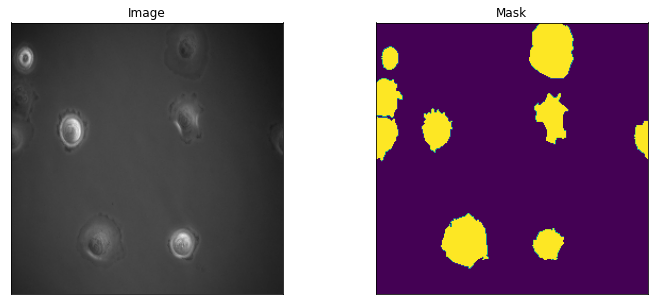

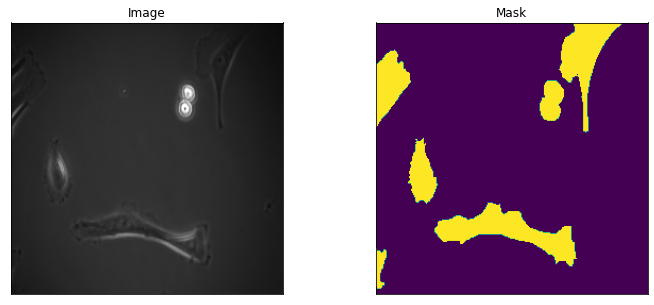

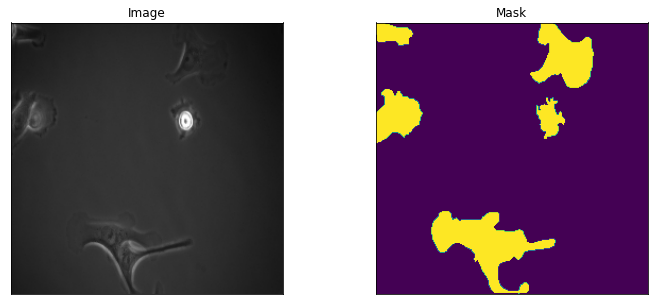

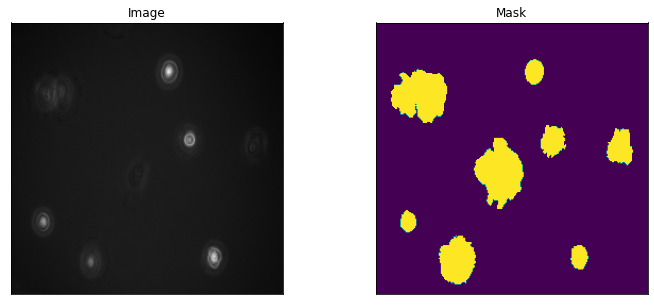

In [ ]:
images, masks = next(train_generator)
for image, mask in zip(images, masks):
    visualize(
        image=image.astype('uint8'),
        mask=np.squeeze(mask)
    )

<a name="cell-id2.2"></a>
### CNN Approaches




```
Backbones
*********************************************************************
VGG
'vgg16' 'vgg19'
ResNet
'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'
SE-ResNet
'seresnet18' 'seresnet34' 'seresnet50' 'seresnet101' 'seresnet152'
ResNeXt
'resnext50' 'resnext101'
SE-ResNeXt
'seresnext50' 'seresnext101'
SENet154
'senet154'
DenseNet
'densenet121' 'densenet169' 'densenet201'
Inception
'inceptionv3' 'inceptionresnetv2'
MobileNet
'mobilenet' 'mobilenetv2'
EfficientNet
'efficientnetb0' 'efficientnetb1' 'efficientnetb2' 'efficientnetb3' 'efficientnetb4' 'efficientnetb5' efficientnetb6' efficientnetb7'
*********************************************************************

```



#### Unet

<div>
<img src="https://camo.githubusercontent.com/d55a437337d0e08c6a082714959253d80b81ce4e6c18e94688d9aff16e3bf2f8/68747470733a2f2f6c6d622e696e666f726d6174696b2e756e692d66726569627572672e64652f70656f706c652f726f6e6e656265722f752d6e65742f752d6e65742d6172636869746563747572652e706e67" width="450"/>
</div>

[Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.](https://https://arxiv.org/pdf/1505.04597.pdf)

In [ ]:
optim = tf.keras.optimizers.Adam(LR)
_dice_loss = sm.losses.DiceLoss() 
_focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = _dice_loss + _focal_loss
metrics = [sm.metrics.IOUScore(threshold=0.5)]
model_filename = '/content/motility_unet_{}_{}_{}.h5'.format(IMG_WIDTH, num_epoch, backbone)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

callbacks = [
    callback_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(),
]

preprocess_input = sm.get_preprocessing(backbone)

model_unet = sm.Unet(
    backbone, 
    encoder_weights='imagenet',
    input_shape=input_shape, 
    classes=n_classes, 
    activation=activation
)

model_unet.compile(
    optimizer=optim,
    loss=total_loss,
    metrics=metrics,
)

history_unet = model_unet.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose = 1
)

44122112/44107200 [==============================] - 0s 0us/step
Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.8302 - iou_score: 0.2938
Epoch 1: loss improved from inf to 0.83025, saving model to /content/motility_unet_256_30_efficientnetb3.h5
7/7 [==============================] - 65s 6s/step - loss: 0.8302 - iou_score: 0.2938 - val_loss: 10.5480 - val_iou_score: 0.1248 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.5998 - iou_score: 0.6105
Epoch 2: loss improved from 0.83025 to 0.59983, saving model to /content/motility_unet_256_30_efficientnetb3.h5
7/7 [==============================] - 6s 924ms/step - loss: 0.5998 - iou_score: 0.6105 - val_loss: 7.6803 - val_iou_score: 0.1094 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.5320 - iou_score: 0.6669
Epoch 3: loss improved from 0.59983 to 0.53202, saving model to /content/motility_unet_256_30_efficientnetb3.h5
7/7 [==============================] 

#### LinkNet

<div>
<img src="https://d3i71xaburhd42.cloudfront.net/7447a957fe1a4922fb7e28cf672d3d84b2963d83/2-Figure1-1.png" width="450"/>
</div>

[Chaurasia, A., & Culurciello, E. (2017, December). Linknet: Exploiting encoder representations for efficient semantic segmentation. In 2017 IEEE Visual Communications and Image Processing (VCIP) (pp. 1-4). IEEE.](https://arxiv.org/pdf/1707.03718.pdf)

In [ ]:
model_filename = '/content/motility_linknet_{}_{}_{}.h5'.format(IMG_WIDTH, num_epoch, backbone)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

callbacks = [
    callback_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(),
]

preprocess_input = sm.get_preprocessing(backbone)

model_linknet = sm.Linknet(
    backbone, 
    encoder_weights='imagenet',
    input_shape=input_shape, 
    classes=n_classes, 
    activation=activation
)

model_linknet.compile(
    optimizer=optim,
    loss=total_loss,
    metrics=metrics,
)

history_linknet = model_linknet.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.7803 - iou_score: 0.3519
Epoch 1: loss improved from inf to 0.78027, saving model to /content/motility_linknet_256_30_efficientnetb3.h5
7/7 [==============================] - 22s 874ms/step - loss: 0.7803 - iou_score: 0.3519 - val_loss: 10.9885 - val_iou_score: 0.1218 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.4487 - iou_score: 0.6967
Epoch 2: loss improved from 0.78027 to 0.44868, saving model to /content/motility_linknet_256_30_efficientnetb3.h5
7/7 [==============================] - 3s 542ms/step - loss: 0.4487 - iou_score: 0.6967 - val_loss: 3.3709 - val_iou_score: 0.1138 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2635 - iou_score: 0.7845
Epoch 3: loss improved from 0.44868 to 0.26353, saving model to /content/motility_linknet_256_30_efficientnetb3.h5
7/7 [==============================] - 4s 556ms/step - loss: 0.2635 - iou_score: 0.7845 - 

#### FPN


<div>
<img src="https://chadrick-kwag.net/wp-content/uploads/2021/01/1.png" width="650"/>
</div>

[Lin, T. Y., Dollár, P., Girshick, R., He, K., Hariharan, B., & Belongie, S. (2017). Feature pyramid networks for object detection. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2117-2125).](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)

In [ ]:
model_filename = '/content/motility_fpn_{}_{}_{}.h5'.format(IMG_WIDTH, num_epoch, backbone)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

callbacks = [
    callback_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(),
]

preprocess_input = sm.get_preprocessing(backbone)

model_fpn = sm.FPN(
    backbone, 
    encoder_weights='imagenet',
    input_shape=input_shape, 
    classes=n_classes, 
    activation=activation
)

model_fpn.compile(
    optimizer=optim,
    loss=total_loss,
    metrics=metrics,
)

history_fpn = model_fpn.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.6917 - iou_score: 0.4183
Epoch 1: loss improved from inf to 0.69174, saving model to /content/motility_fpn_256_30_efficientnetb3.h5
7/7 [==============================] - 23s 977ms/step - loss: 0.6917 - iou_score: 0.4183 - val_loss: 6.6117 - val_iou_score: 0.1672 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.2554 - iou_score: 0.6935
Epoch 2: loss improved from 0.69174 to 0.25539, saving model to /content/motility_fpn_256_30_efficientnetb3.h5
7/7 [==============================] - 4s 636ms/step - loss: 0.2554 - iou_score: 0.6935 - val_loss: 4.8188 - val_iou_score: 0.1530 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.1857 - iou_score: 0.7631
Epoch 3: loss improved from 0.25539 to 0.18565, saving model to /content/motility_fpn_256_30_efficientnetb3.h5
7/7 [==============================] - 4s 567ms/step - loss: 0.1857 - iou_score: 0.7631 - val_loss: 1.3

<a name="cell-id3"></a>
## **3.** 📊 Analysis

<div>
<img src="https://www.researchgate.net/publication/347086286/figure/fig4/AS:970329174319104@1608355911945/Schematic-figure-of-the-intersection-over-union-IoU-and-the-segmentation-accuracy-for.png" width="560"/>
</div>

**${\displaystyle IoU(A,B)={{|A\cap B|} \over {|A\cup B|}}={{|A\cap B|} \over {|A|+|B|-|A\cap B|}}}$**  

In [ ]:
def IoU(y_true, y_pred, threshold=0.5, smooth=1e-4):
    """
    The Intersection over Union, or Jaccard similarity coefficient, defined as
    the size of the intersection divided by the size of the union of two label
    sets, is used to compare set of predicted labels for a sample to the
    corresponding set of labels in ``y_true``.
    Parameters
    ----------
    y_true : 2d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    y_pred : 2d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a segmentation model.
    threshold : float, default=0.5
        It takes a value between 0 and 1. It is used to threshold 
        the predicted values.
    smooth : float, default=1e-4
        Use the smooth to avoid division by 0. Added it to both the 
        numerator and denominator to prevent it from affecting the 
        coefficient in any other case.
    Returns
    -------
    score : float 
        Intersection over union score.
    """
    def threshold_binarize(x, threshold=0.5):
        ge = tf.greater_equal(x, tf.constant(threshold))
        y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
        return y
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [ ]:
test_params = {
    'to_fit':True,
    'batch_size': 1,
    'dim': (IMG_WIDTH, IMG_HEIGHT),
    'dtype':'float32',
    'n_channels': IMG_CHANNELS,
    'n_classes': n_classes,
    'shuffle': False,
}
test_generator = DataGenerator(test_img_path, test_mask_path, **test_params)
cnn_models = [model_unet, model_linknet, model_fpn]
iou_scores={
    'unet':[],
    'linknet':[],
    'fpn':[],
    'svm':[],
    'random_forest':[],
    'gradient_boosting':[]
}
for cnn_model, model_name in zip(cnn_models, list(iou_scores.keys())[:3]):
    for i in range(len(test_generator)):
        image, mask = next(test_generator)
        prediction = cnn_model.predict(image)
        generated_mask = np.squeeze(prediction)
        iou_scores[model_name].append(float(IoU(np.squeeze(mask), generated_mask)))

In [ ]:
mask_paths = []
for mask in next(os.walk(test_mask_path))[-1]:
    mask_paths.append(test_mask_path + os.sep + mask)
mask_paths.sort(key=natural_keys)
ml_models = [model_svm, model_randomforest, model_gradientboosting]
for ml_model, model_name in zip(ml_models, list(iou_scores.keys())[3:]):
    test_generator = DataGenerator(test_img_path, batch_size=1, to_fit=False)
    for i in range(len(test_generator)):
        features = next(test_generator)
        prediction = ml_model.predict(features.reshape(-1, features.shape[1]))
        size = int(np.sqrt(len(prediction)))
        prediction = prediction.reshape((size, size))
        generated_mask = np.squeeze(prediction)
        mask = cv2.imread(mask_paths[i], 0)
        mask = cv2.resize(mask, (size, size))
        mask[:, :][mask[:, :] > 1] = 1
        iou_scores[model_name].append(
            float(IoU(np.squeeze(mask).astype(np.float32), 
                      generated_mask.astype(np.float32)))
        )


<h3>
  📈 Analysis
</h3>




In [ ]:
def plot_IoU_framebyframe(scores, x_size):
    """
    Visualize the measured IoU scores for each frame as a line chart.
    Parameters
    ----------
    scores : dictionary
        Keys contain model names and values ​​as a list the IoU score 
        for each frame.
    x_size : int
        Number of frames.
    """
    x_label = [str(i+1) for i in range(x_size)]

    fig = go.Figure()
    for key in scores.keys():
        fig.add_trace(go.Scatter(
            x=x_label, y=scores[key],
            mode='markers+lines',
            name=key,
            marker_size=8,
            marker_line_width=2
        ))

    fig.update_layout(
        title_text='IoU Score Frame by Frame',
        showlegend=True,
        yaxis=dict(
            title="IoU",
            showgrid=False,
            showline=False, 
            showticklabels=True,
        ),
        xaxis=dict(
            title="Frames",
            zeroline=False,
            showline=False,
            showticklabels=True,
            showgrid=True,
            tickvals = x_label,
            ticks="outside",
            tickson="boundaries",
            ticklen=5
        ),
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        width=750,
        height=600)
    fig.show()

def plot_AVGIoU(scores):
    """
    Visualize the measured IoU scores for each frame as a bar chart.
    Parameters
    ----------
    scores : dictionary
        Keys contain model names and values ​​as a list the IoU score 
        for each frame.
    """
    fig = go.Figure()
    for key in scores.keys():
        fig.add_trace(go.Box(
            y=scores[key],
            name = key,
            marker_color='dodgerblue',
            boxpoints='all',
            boxmean='sd',
            jitter=0.5,
            whiskerwidth=0.9,
            marker_size=2,
            line_width=1
        ))

    fig.update_layout(
        title_text='Avg. IoU Score',
        showlegend=True,
        yaxis=dict(
            title="IoU",
            showgrid=False,
            showline=False,
            showticklabels=True,
        ),
        xaxis=dict(
            title="Models",
            autorange=True,
            showgrid=True,
            zeroline=True,
            gridcolor='rgb(255, 255, 255)',
            gridwidth=1,
            zerolinecolor='rgb(255, 255, 255)',
            zerolinewidth=2,
        ),
        width=650,
        height=450)
    fig.show()

def plot_ROCIoU(iou_scores):
    """
    Visualize the IoU performance of models as a line graph at thresholds 
    ranging from 0 to 1. (Similar to the ROC curve.)
    Parameters
    ----------
    iou_scores : dictionary
        Keys contain model names and values ​​as a list the IoU score 
        for each frame.
    """
    x_label = ["{:.1f}".format(i) for i in np.arange(0.0, 1.1, 0.1, 'float32')]

    fig = go.Figure()
    for key in iou_scores.keys():
        fig.add_trace(go.Scatter(
            x=x_label, y=iou_scores[key],
            mode='markers+lines',
            name=key,
            marker_size=8,
            marker_line_width=2
        ))

    fig.update_layout(
        title_text='Change of IoU score below threshold',
        showlegend=True,
        yaxis=dict(
            title="IoU",
            showgrid=False,
            showline=False, 
            showticklabels=True,
        ),
        xaxis=dict(
            title="threshold",
            zeroline=False,
            showline=False,
            showticklabels=True,
            showgrid=True,
            tickvals = x_label,
            ticks="outside",
            tickson="boundaries",
            ticklen=5
        ),
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        width=750,
        height=600)
    fig.show()

In [ ]:
plot_IoU_framebyframe(iou_scores, len(test_generator))

In [ ]:
plot_AVGIoU(iou_scores)

In [ ]:
iou_scores={
    'unet':[],
    'linknet':[],
    'fpn':[],
}
for cnn_model, model_name in zip(cnn_models, iou_scores.keys()):
    iou = []
    for threshold in np.arange(0, 1.1, 0.1, np.float32):
        for i in range(len(test_generator)):
            image, mask = next(test_generator)
            prediction = cnn_model.predict(image)
            generated_mask = np.squeeze(prediction)
            iou.append(float(IoU(
                np.squeeze(mask), generated_mask, threshold=threshold
            )))
        iou_scores[model_name].append(np.mean(iou))

plot_ROCIoU(iou_scores)

###2D Filtered ML Models vs DL Models IoU Scores

In [ ]:
iou_scores_filtered={
    'unet':[],
    'linknet':[],
    'fpn':[],
    'svm':[],
    'random_forest':[],
    'gradient_boosting':[]
}
mask_paths = []
for mask in next(os.walk(test_mask_path))[-1]:
    mask_paths.append(test_mask_path + os.sep + mask)
mask_paths.sort(key=natural_keys)
ml_models = [model_svm, model_randomforest, model_gradientboosting]
for ml_model, model_name in zip(ml_models, list(iou_scores_filtered.keys())[3:]):
    test_generator = DataGenerator(test_img_path, batch_size=1, to_fit=False, feature_type='filtered')
    for i in range(11):
        features = next(test_generator)
        prediction = ml_model.predict(features.reshape(-1, features.shape[1]))
        size = int(np.sqrt(len(prediction)))
        prediction = prediction.reshape((size, size))
        generated_mask = np.squeeze(prediction)
        mask = cv2.imread(mask_paths[i], 0)
        mask = cv2.resize(mask, (size, size))
        mask[:, :][mask[:, :] > 1] = 1
        iou_scores_filtered[model_name].append(
            float(IoU(np.squeeze(mask).astype(np.float32), 
                      generated_mask.astype(np.float32)))
        )

In [ ]:
iou_scores_filtered['fpn'] = iou_scores['fpn']
iou_scores_filtered['unet'] = iou_scores['unet']
iou_scores_filtered['linknet'] = iou_scores['linknet']
plot_IoU_framebyframe(iou_scores_filtered, len(test_generator))

In [ ]:
plot_AVGIoU(iou_scores_filtered)

### Visual Results



<h3>
  🔰 Unet Visual Results
</h3>

In [ ]:
def dlmodel_output_visualize(model, generator):
    """
    Generate visual outputs for the given tf.keras model. They are the input (original) 
    image, the ground truth mask, and the resulting (predicted) mask, respectively.
    Parameters
    ----------
    model : keras.engine.functional.Functional
        Pre-trained tensorflow.keras model.
    generator : DataGenerator
        It is a data generator that generates images and masks.
    """
    for _ in range(len(generator)):
        image, mask = next(generator)
        prediction = model.predict(image)
        generated_mask = np.squeeze(prediction)
        visualize(
            image = np.squeeze(image).astype('uint8'),
            ground_truth = np.squeeze(mask),
            generated_mask = generated_mask
        )

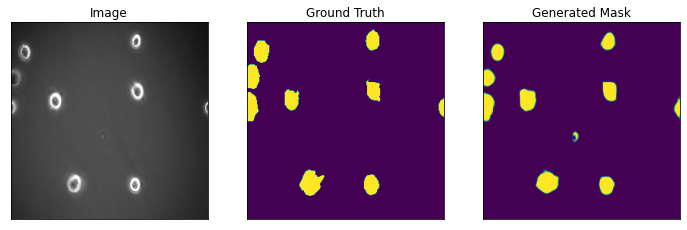

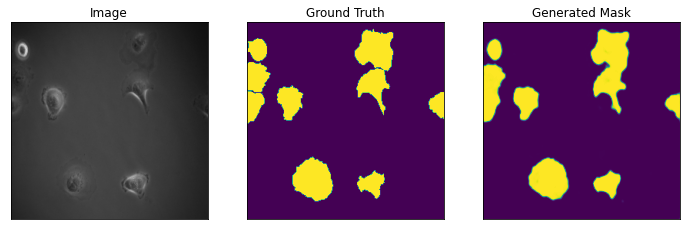

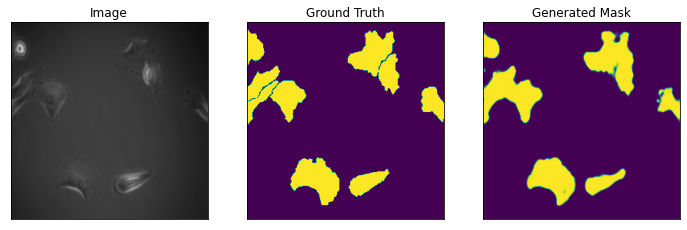

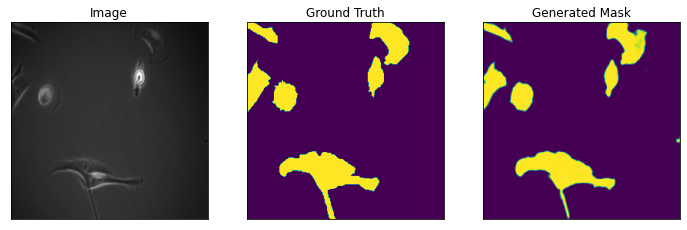

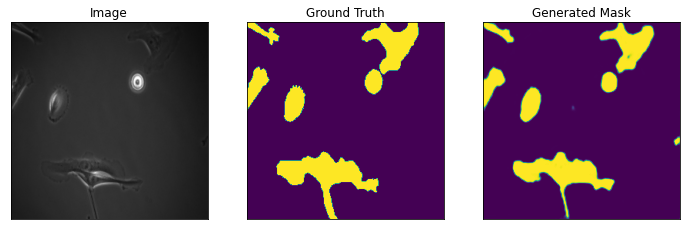

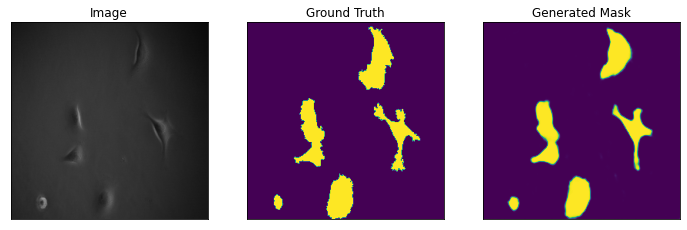

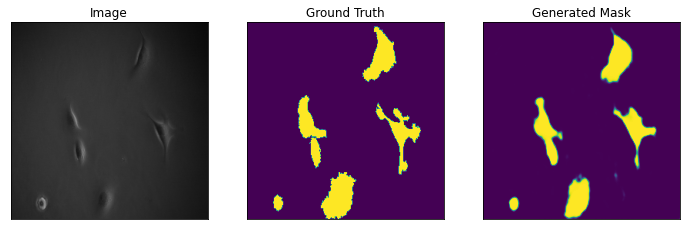

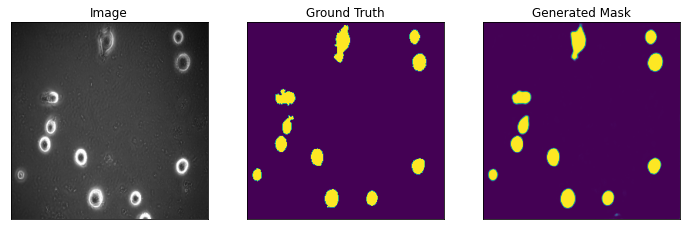

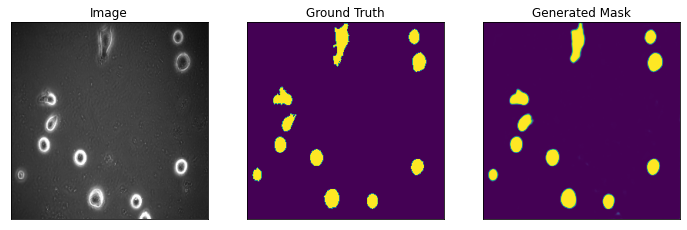

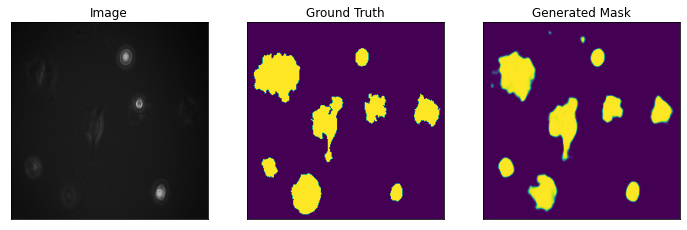

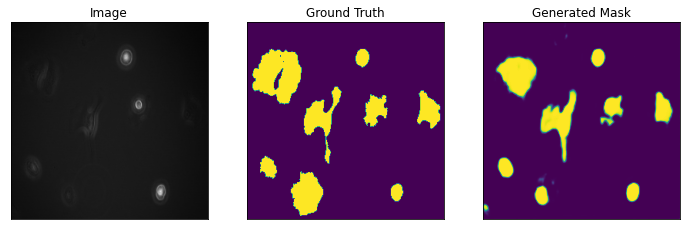

In [ ]:
dlmodel_output_visualize(model_unet, test_generator)

<h3>
  🔰 Linknet Visual Results
</h3>

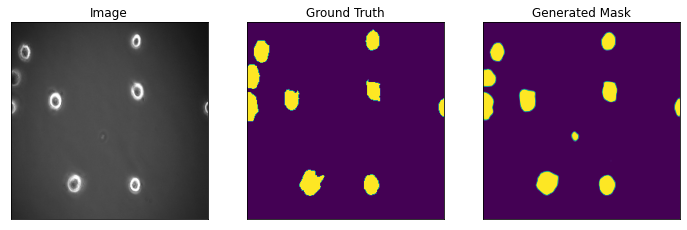

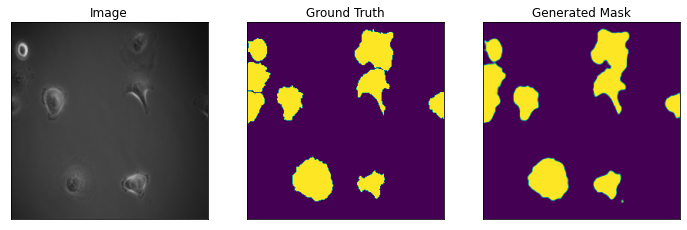

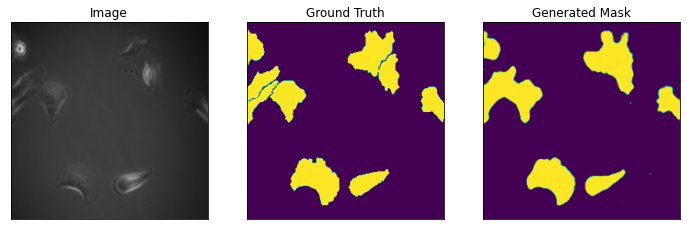

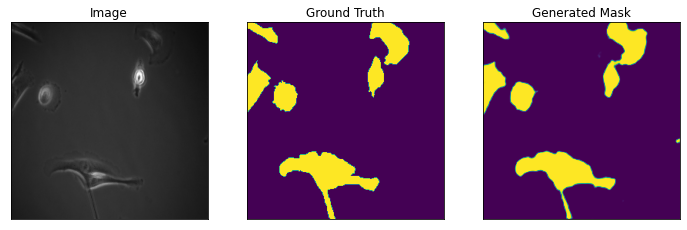

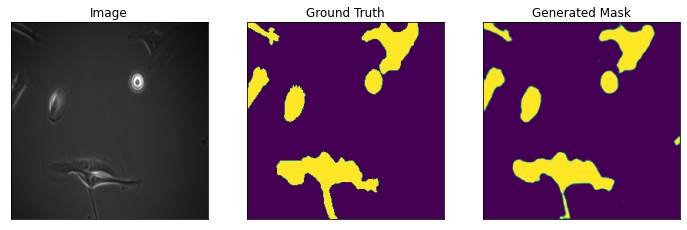

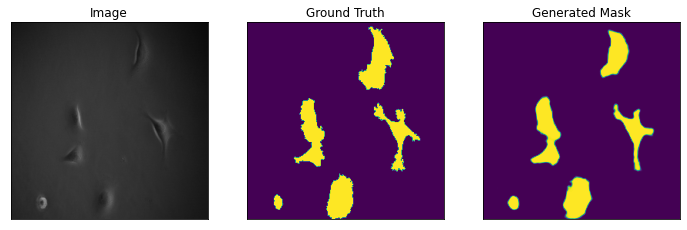

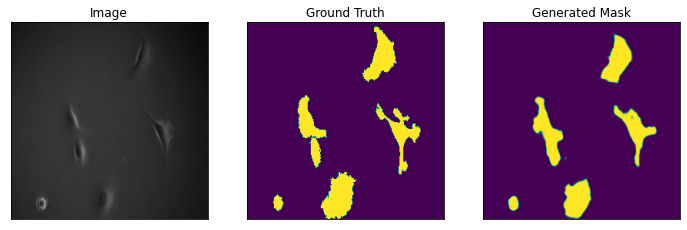

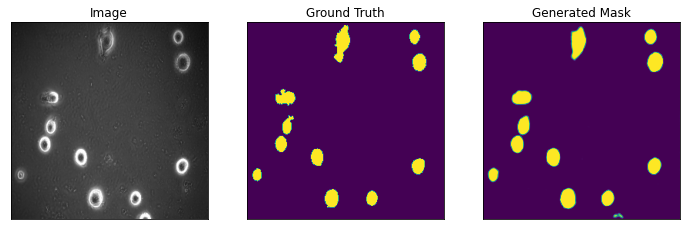

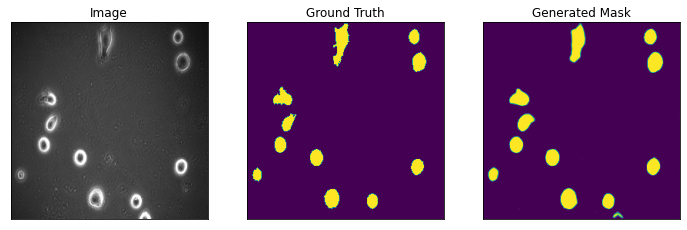

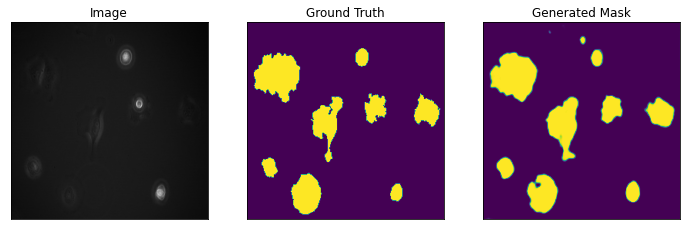

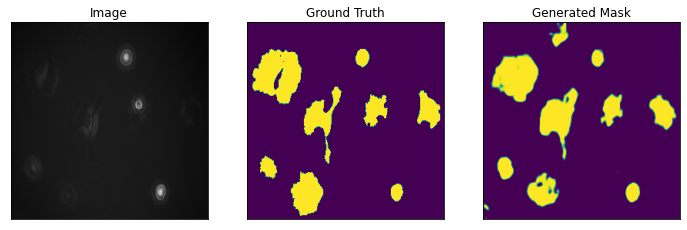

In [ ]:
dlmodel_output_visualize(model_linknet, test_generator)

<h3>
  🔰 FPN Visual Results
</h3>

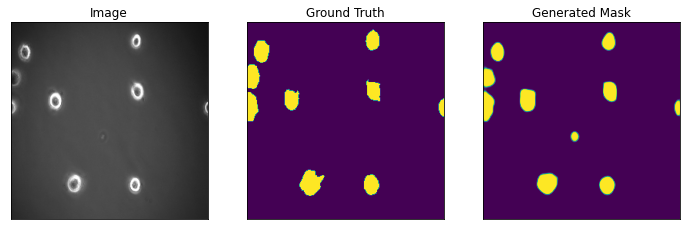

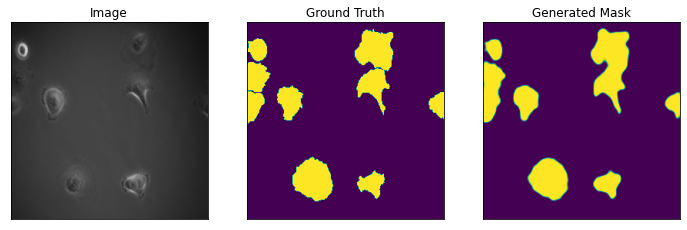

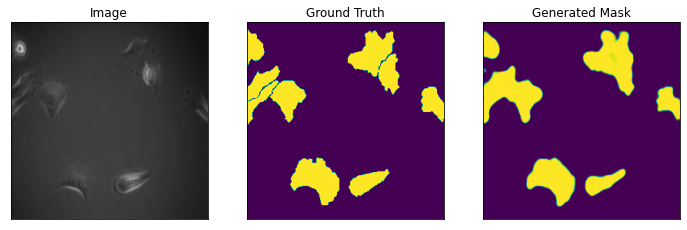

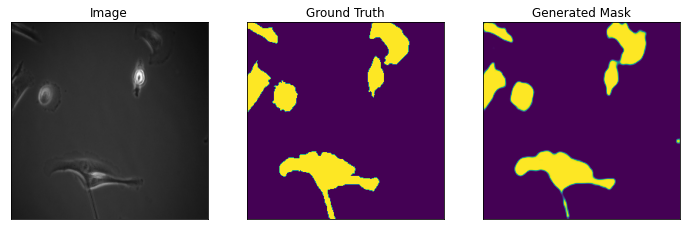

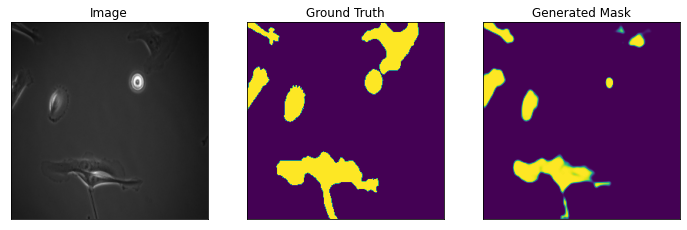

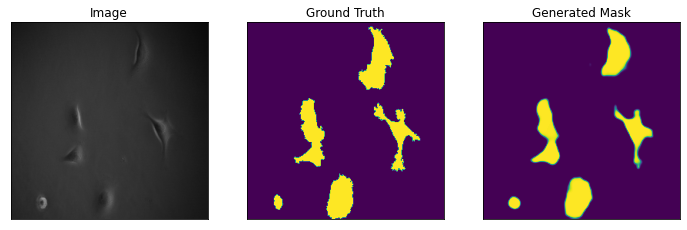

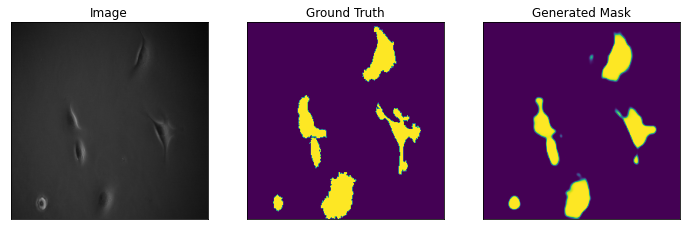

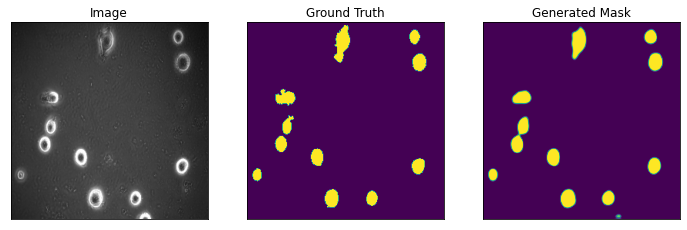

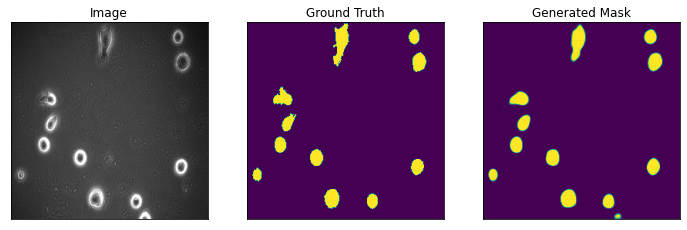

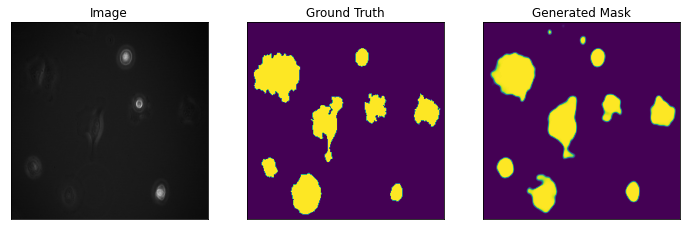

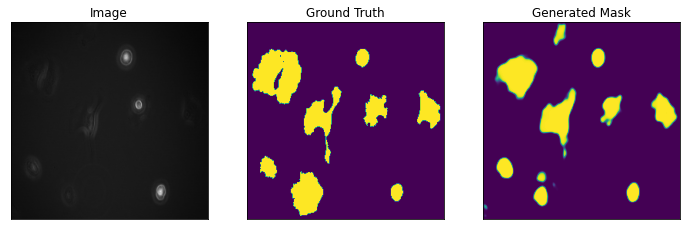

In [ ]:
dlmodel_output_visualize(model_fpn, test_generator)

<h3>
  🔰 SVM Visual Results (2D Filtered Features)
</h3>

In [ ]:
def mlmodel_output_visualize(model, generator, img_dir, mask_dir):
    """
    Generate visual outputs for the given ML model. They are the input (original) 
    image, the ground truth mask, and the resulting (predicted) mask, respectively.
    Parameters
    ----------
    model : sklearn unsupervised learning models
        Trained sklearn.model.
    generator : DataGenerator
        It is a data generator that generates features.
    img_dir : list
        File directory of images are given to the data generator.
    mask_dir : list
        File directory of masks are given to the data generator.
    """
    mask_paths = []
    for mask in next(os.walk(test_mask_path))[-1]:
        mask_paths.append(test_mask_path + os.sep + mask)
    mask_paths.sort(key=natural_keys)

    img_paths = []
    for mask in next(os.walk(test_img_path))[-1]:
        img_paths.append(test_img_path + os.sep + mask)
    img_paths.sort(key=natural_keys)
    
    for mask_path, img_path in zip(mask_paths, img_paths):
        mask = cv2.imread(mask_path, 0)
        img = cv2.imread(img_path)
        features = next(generator)
        prediction = model.predict(features.reshape(-1, features.shape[1]))
        size = int(np.sqrt(len(prediction)))
        prediction = prediction.reshape((size, size))
        generated_mask = np.squeeze(prediction)
        ground_truth = cv2.resize(mask, (size, size)) 
        img = cv2.resize(img, (size, size))
        visualize(
            image = img, 
            ground_truth = ground_truth,
            generated_mask = generated_mask
        )


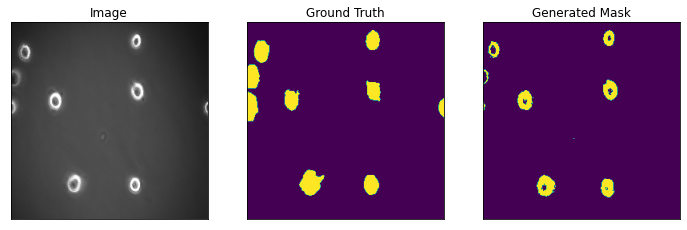

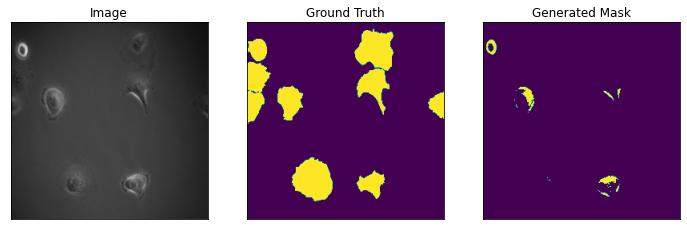

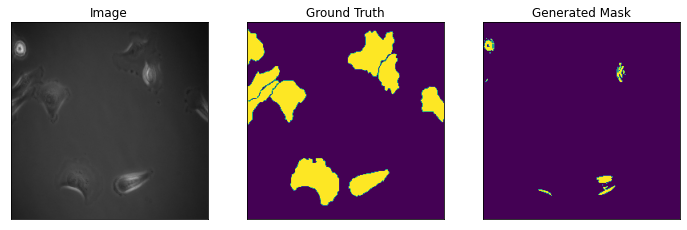

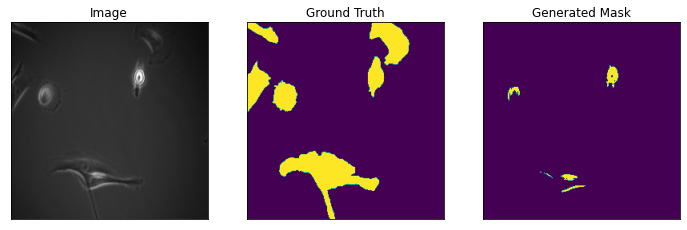

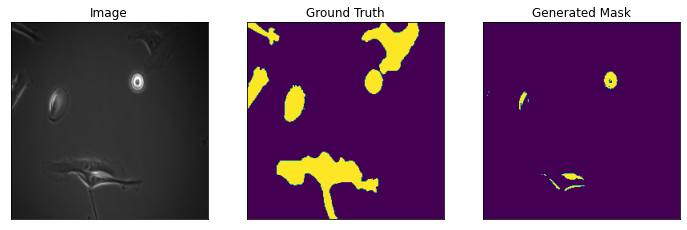

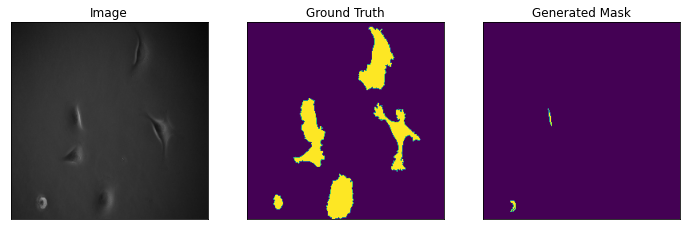

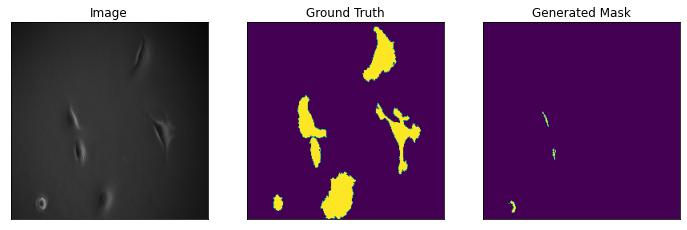

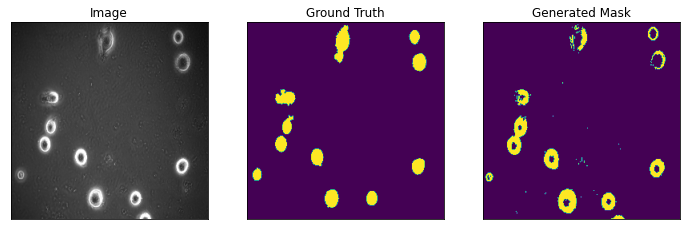

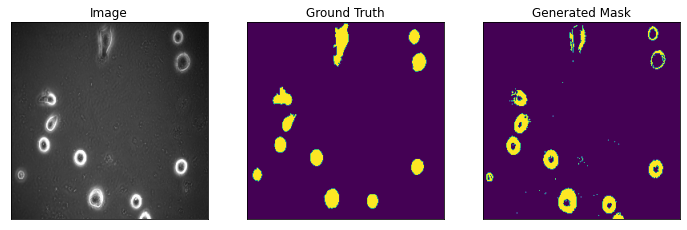

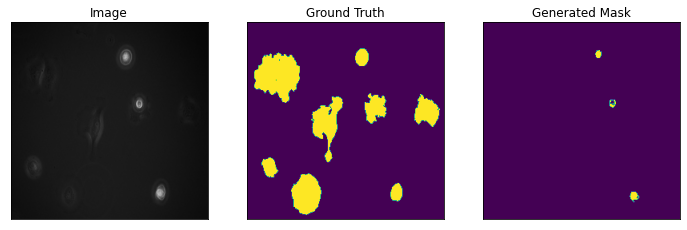

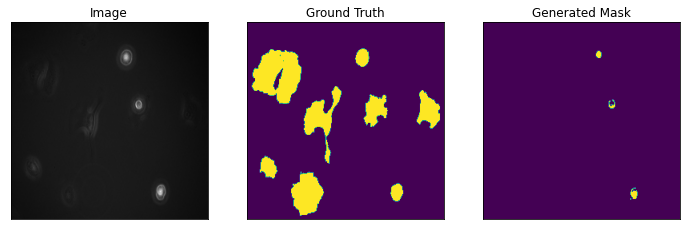

In [ ]:
mlmodel_output_visualize(model_svm, test_generator, test_img_path, test_mask_path)

<h3>
  🔰 SVM Visual Results (Haralick Features)
</h3>

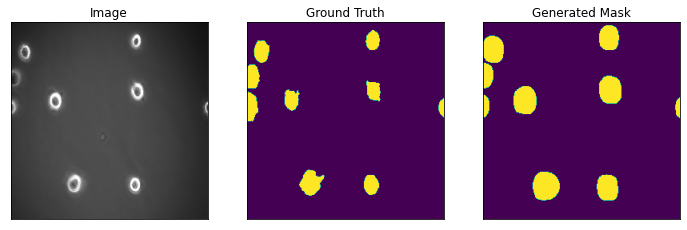

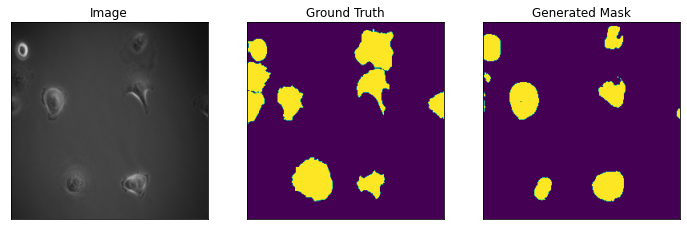

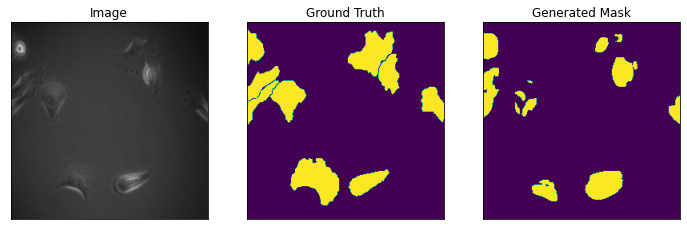

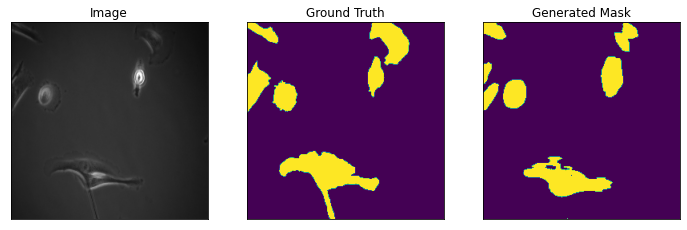

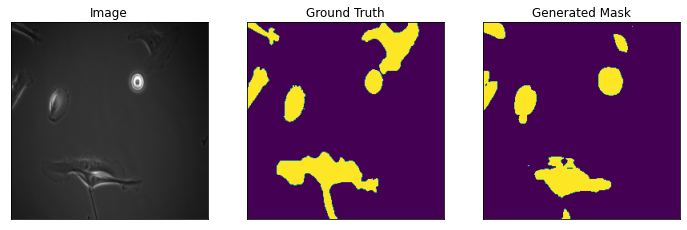

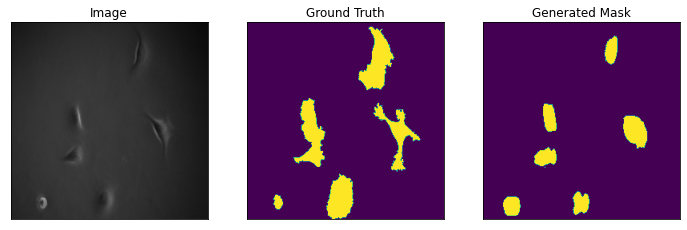

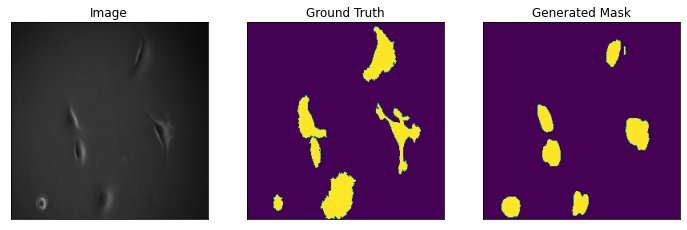

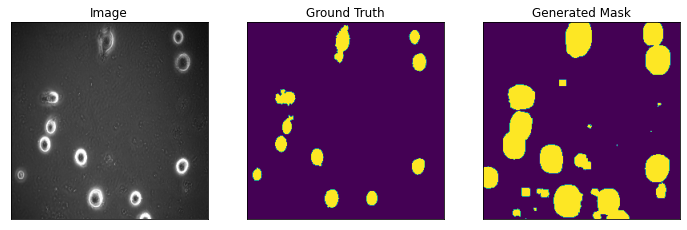

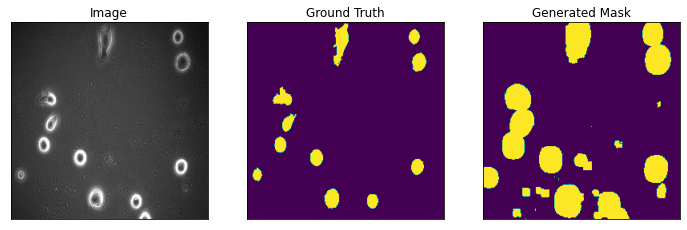

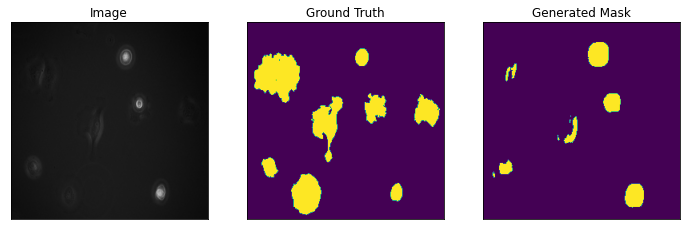

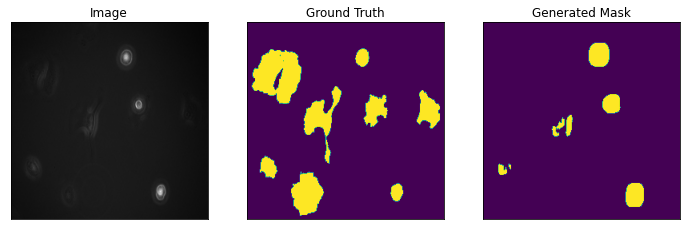

In [ ]:
mlmodel_output_visualize(model_svm, test_generator, test_img_path, test_mask_path)

<h3>
  🔰 RandomForest Visual Results (2D Filtered Features)
</h3>

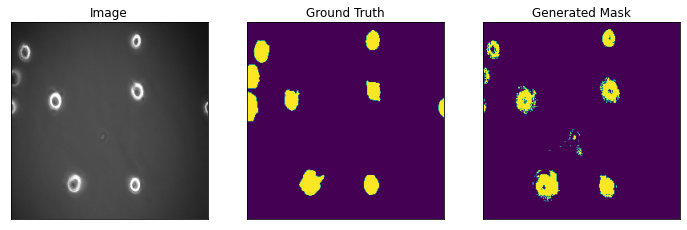

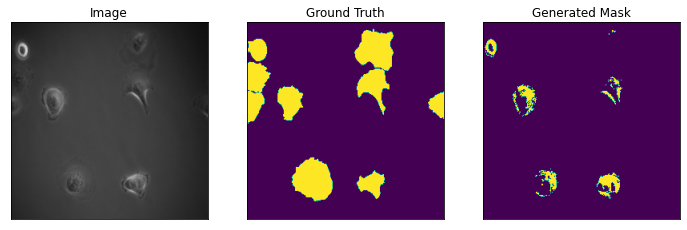

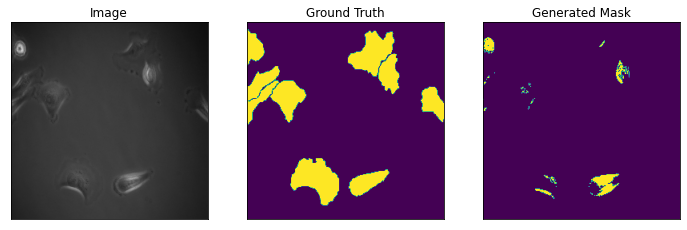

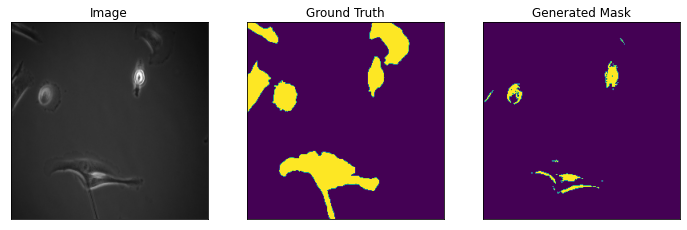

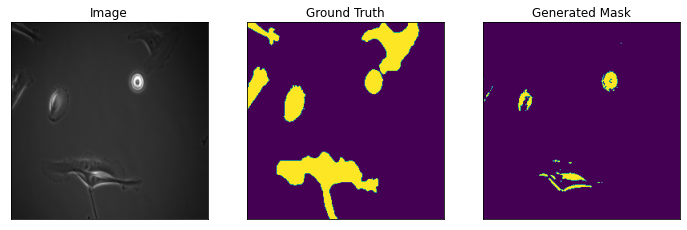

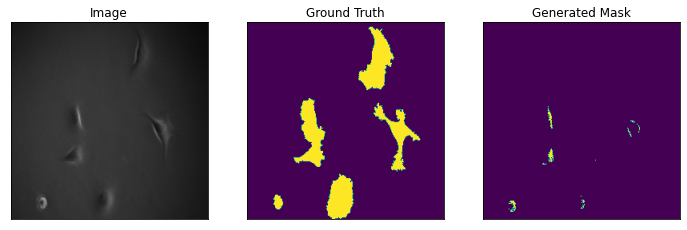

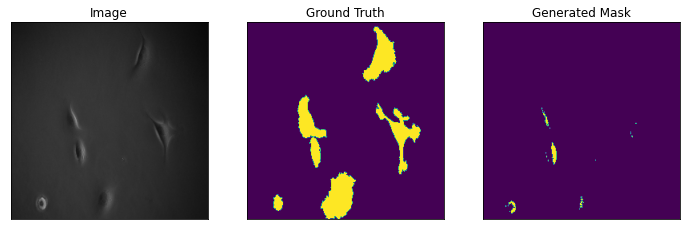

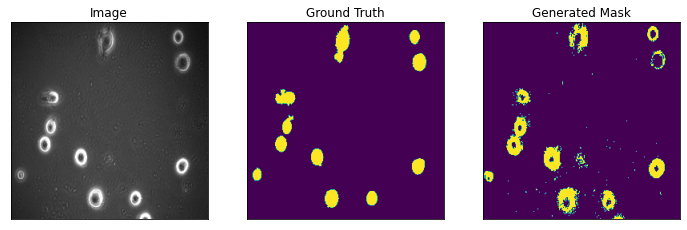

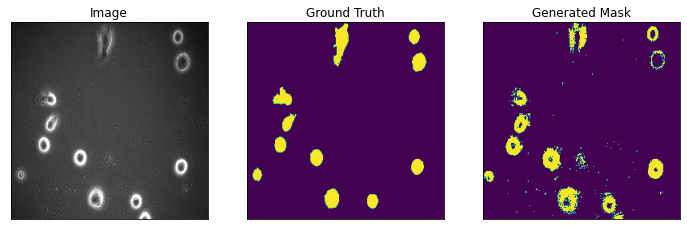

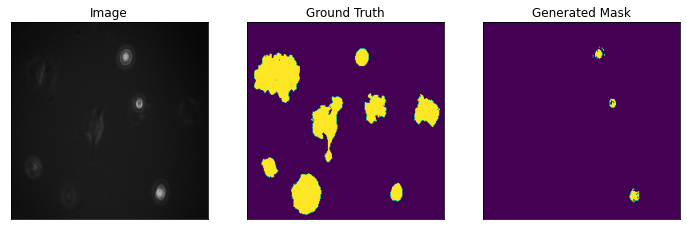

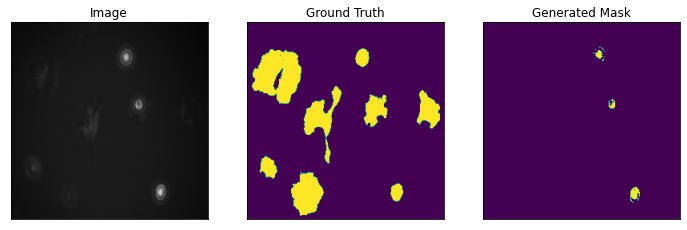

In [ ]:
mlmodel_output_visualize(model_randomforest, test_generator, test_img_path, test_mask_path)

<h3>
  🔰 RandomForest Visual Results (2D Haralick Features)
</h3>

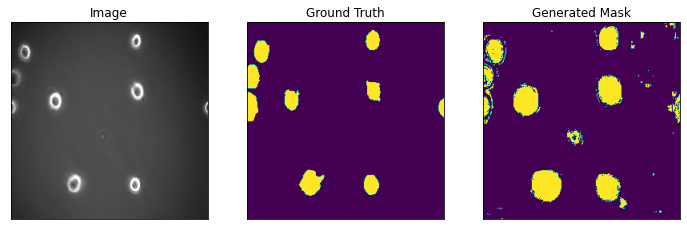

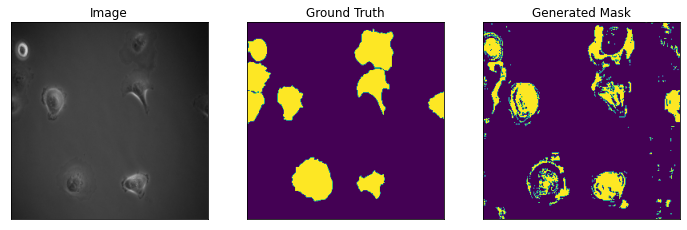

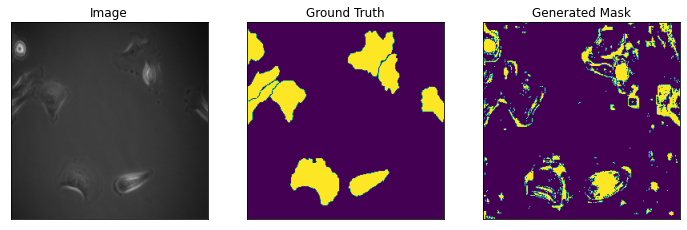

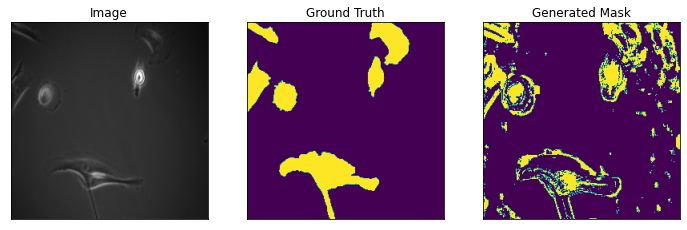

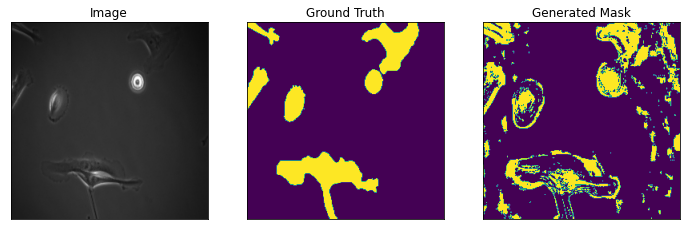

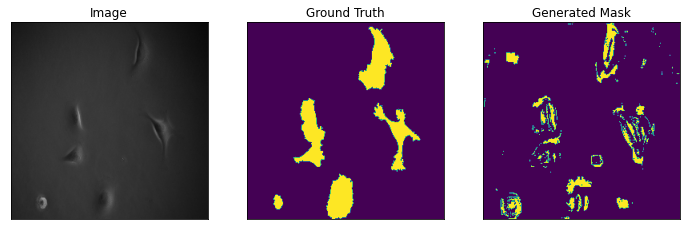

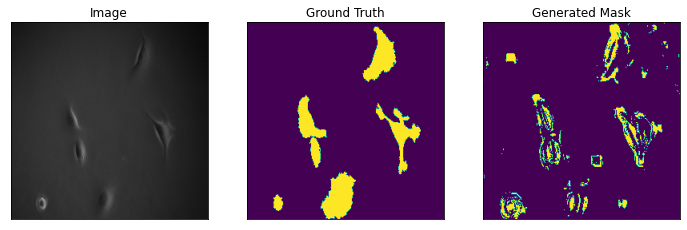

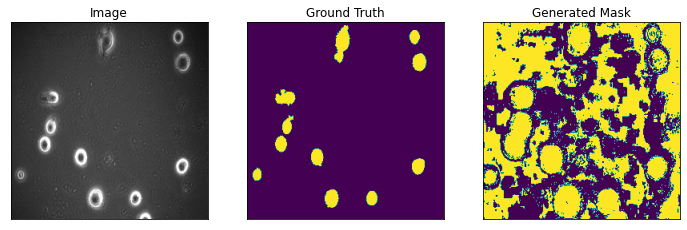

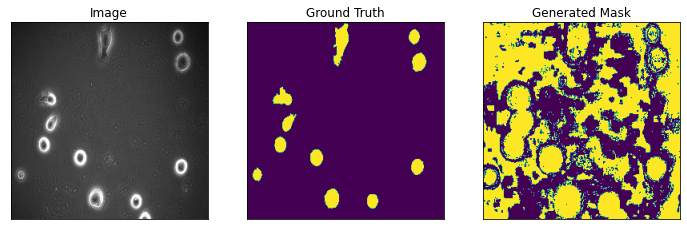

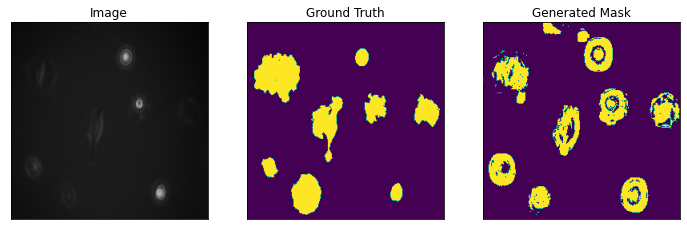

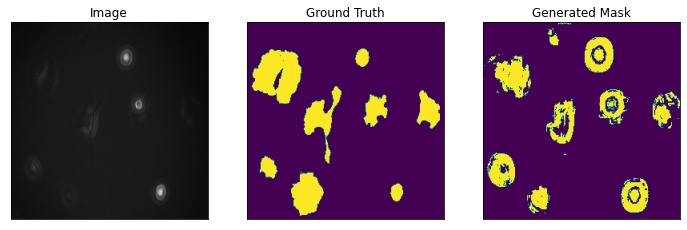

In [ ]:
mlmodel_output_visualize(model_randomforest, test_generator, test_img_path, test_mask_path)

<h3>
  🔰 GradientBoosting Visual Results (2D Filtered Features)
</h3>

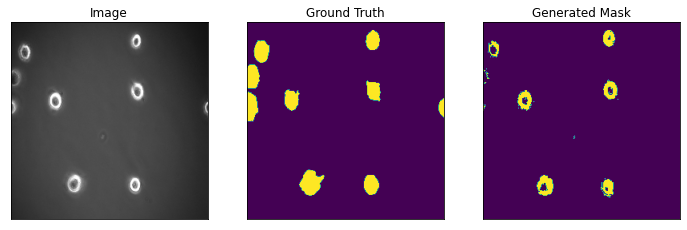

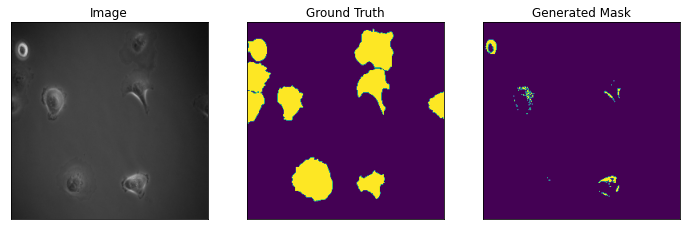

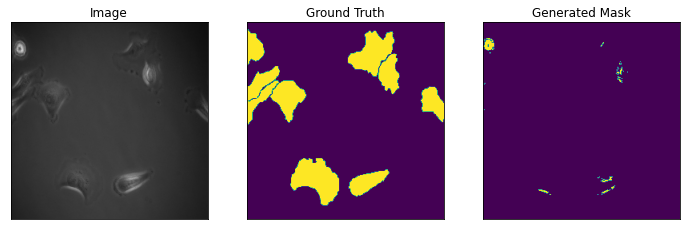

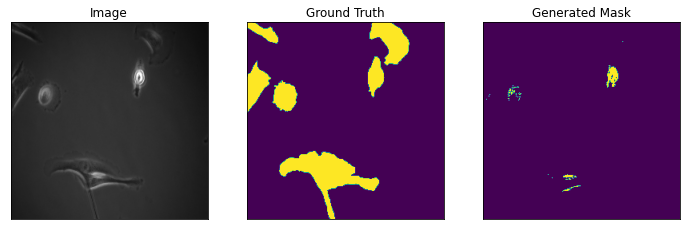

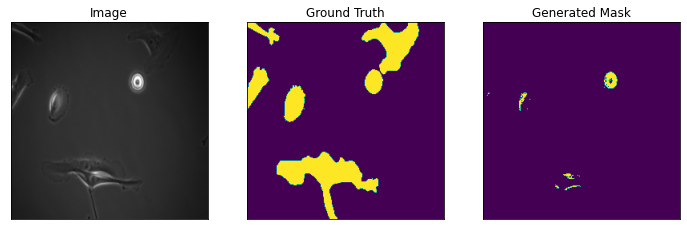

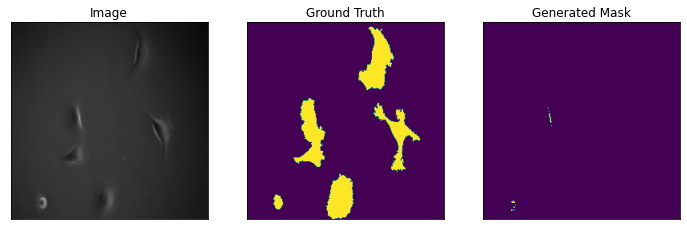

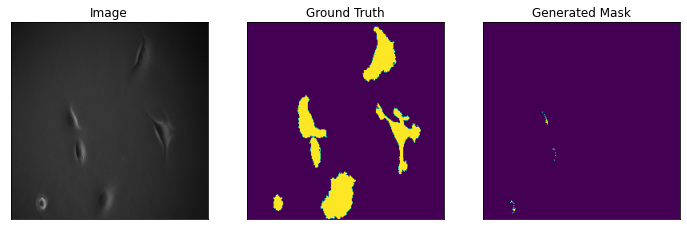

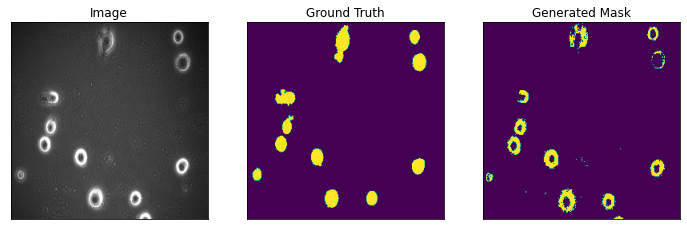

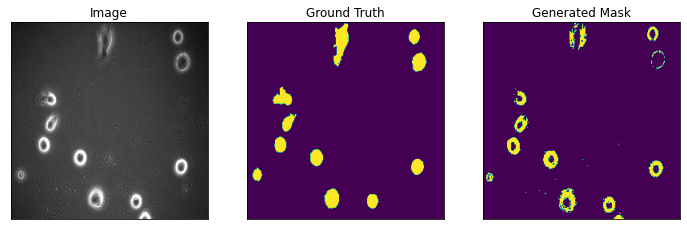

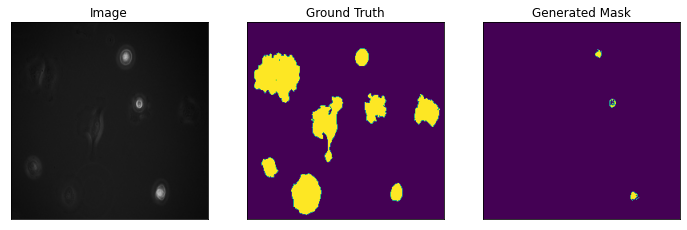

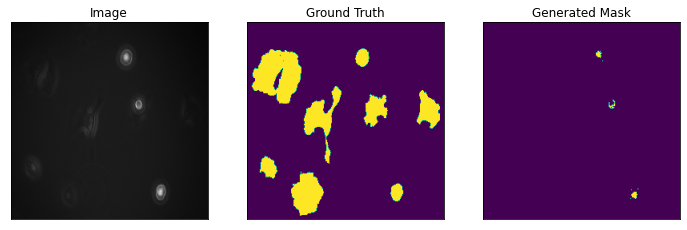

In [ ]:
mlmodel_output_visualize(model_gradientboosting, test_generator, test_img_path, test_mask_path)

<h3>
  🔰 GradientBoosting Visual Results (Haralick Features)
</h3>

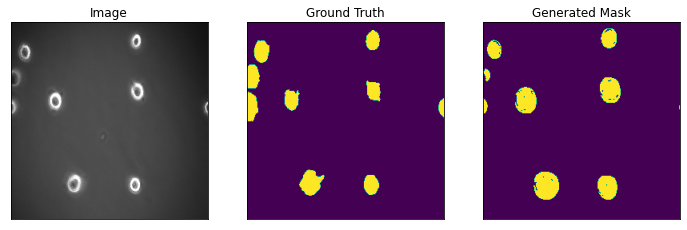

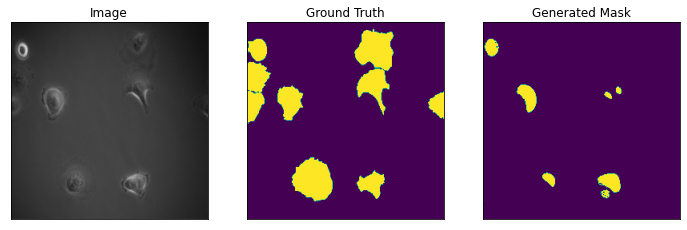

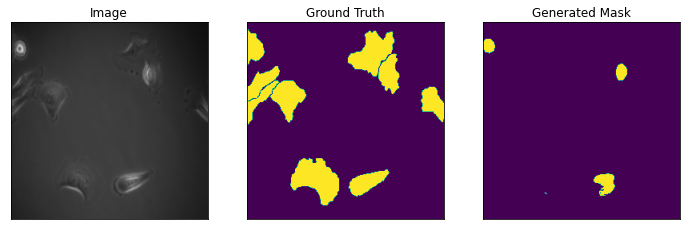

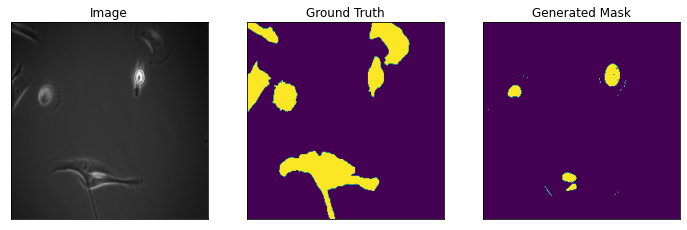

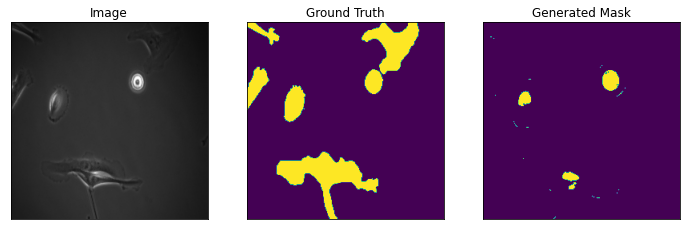

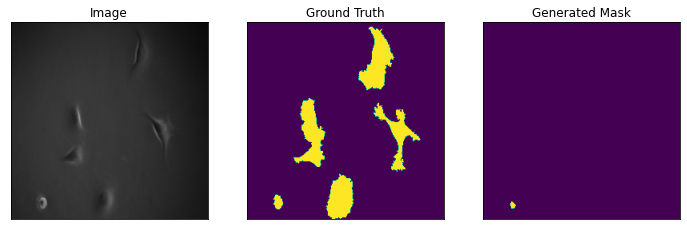

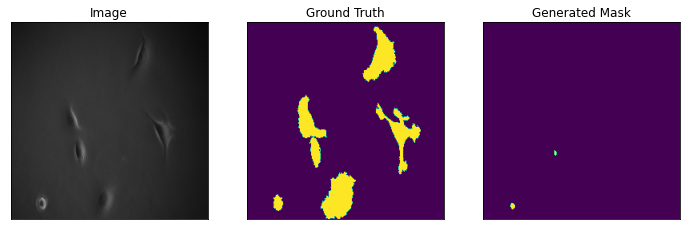

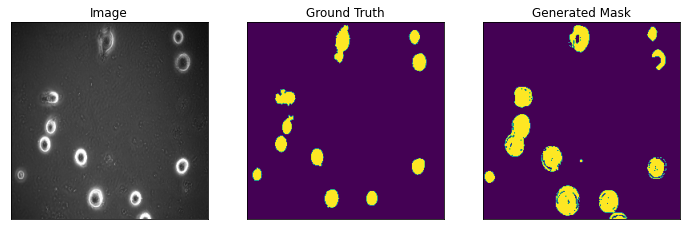

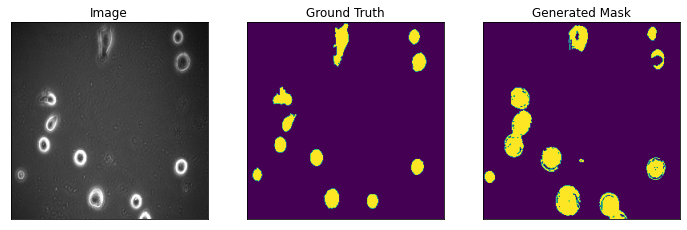

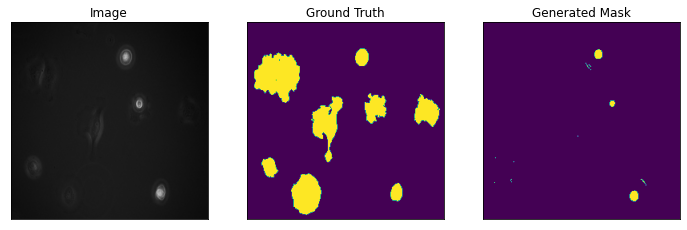

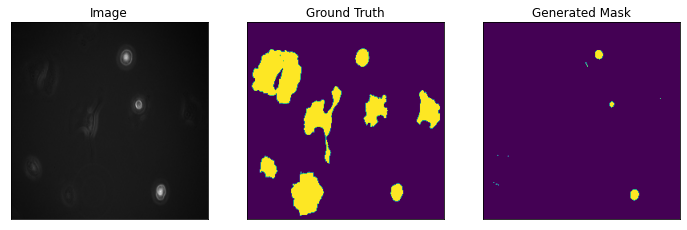

In [ ]:
mlmodel_output_visualize(model_gradientboosting, test_generator, test_img_path, test_mask_path)

<a name="cell-id5"></a>
#**References**

*   [LBP (Local Binary Patterns)](https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/)
*   [R. M. Haralick, K. Shanmugam and I. Dinstein, "Textural Features for Image Classification," in IEEE Transactions on Systems, Man, and Cybernetics, vol. SMC-3, no. 6, pp. 610-621, Nov. 1973, doi: 10.1109/TSMC.1973.4309314.](https://doi.org/10.1109/TSMC.1973.4309314)
*   [Brynolfsson, P., Nilsson, D., Torheim, T. et al. Haralick texture features from apparent diffusion coefficient (ADC) MRI images depend on imaging and pre-processing parameters. Sci Rep 7, 4041 (2017).](https://doi.org/10.1038/s41598-017-04151-4)

*   [Data generator](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)
*   [Haralick texture feature classification](https://gogul.dev/software/texture-recognition)

*   [Scikit-Learn](https://scikit-learn.org/stable/)
*   [Plotly](https://plotly.com/python/ml-regression/)
*   [scikit-image](https://scikit-image.org/)
*   [tensorflow](https://www.tensorflow.org/)
*   [segmentation-models](https://github.com/qubvel/segmentation_models)
*   [Mahotas](https://mahotas.readthedocs.io/en/latest/)
